In [ ]:
pip install statsforecast

In [ ]:
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git


In [ ]:
# !pip install numpy pandas matplotlib tqdm


In [ ]:
pip install dart

#                         TESLA stock price prediction

In [ ]:
#Importing required libraries.
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from tqdm.autonotebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:



df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=True, index_col='Date')


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df.tail()

The columns in the dataset are Open, High, Low, Close, Adj Close, and Volume.

**Finding**: The data set is a stock price dataset consist of daily data from "6/29/2010" till "6/6/2024"

In [ ]:
# The data is sorted by date
df = df.sort_index()


In [ ]:
# Use the 'Close' price for time series analysis
ts = df['Close']

In [ ]:
df.dtypes

In [ ]:
df.isnull().sum()  #checking for missing values

There are no missing values in the dataset.


In [ ]:
df.describe()  #describing the data

The dataset contains 3509 rows with a date range from 2010-06-29 to 2024-06-06.

**Visualisation**

In [ ]:


#Resample the data to check monthly, quarterly, and yearly frequencies and plot the results
monthly_data = df['Close'].resample('M').mean()
quarterly_data = df['Close'].resample('Q').mean()
yearly_data = df['Close'].resample('Y').mean()

plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(monthly_data, label='Monthly Mean Close Price')
plt.title('Monthly Mean Close Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(quarterly_data, label='Quarterly Mean Close Price')
plt.title('Quarterly Mean Close Price')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(yearly_data, label='Yearly Mean Close Price')
plt.title('Yearly Mean Close Price')
plt.legend()

plt.tight_layout()
plt.show()
#  Visualize the data using various plots (line plots, histograms, heatmaps)
plt.figure(figsize=(14, 8))
plt.plot(df['Close'], label='Daily Close Price')
plt.title('Daily Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 8))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Histogram of Close Prices')
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()




#**Monthly, Quarterly, and Yearly Mean Close Prices:**
This plot shows the resampled data at different frequencies, providing insights into the trends over different time periods.

**Monthly Mean Close Price**:There are noticeable fluctuations, indicating periods of rapid growth and occasional declines.

**Quarterly Mean Close Price**: The quarterly resampled data smooths out some of the short-term volatility seen in the monthly data. This plot is useful for identifying medium-term trends. The general upward trend in Tesla's stock price is more evident in this plot.

**Yearly Mean Close Price**: The yearly resampled data provides a long-term view of Tesla's stock performance. This plot shows a clear upward trend, indicating significant growth over the years. The yearly averages help in understanding the overall performance and long-term trends.

**Daily Close Price Line Plot**: This plot shows the daily closing prices of Tesla stock over the entire dataset.#The overall trend is upward, but there are several periods of significant volatility, especially in recent years.

**Histogram of Close Prices**: This histogram shows the distribution of the closing prices, with a kernel density estimate (KDE) overlay #The histogram indicates that the majority of closing prices are concentrated in the lower range, with a long tail extending to higher prices. This suggests that while Tesla's stock has experienced significant growth, it has spent a considerable amount of time at lower price levels.

**Heatmap of Correlation Matrix**: This heatmap shows the correlation between different columns in the dataset #High correlation between Open, High, Low, and Close prices: This is expected as these prices are closely related to each other within a trading day.

The trading volume does not have a strong linear relationship with the stock prices. This suggests that other factors, such as market sentiment and external events, may play a significant role in determining the trading volume.

In [ ]:
df['Open'].plot(figsize=(12,6))

There is a gradual increase in the price from 2020. Also There seems
to be a seasonality which shows spikes every year.

In [ ]:
df['High'].plot(figsize=(12,6))

In [ ]:
df['Low'].plot(figsize=(12,6))

In [ ]:

plt.figure(figsize=(12, 6));
plt.title('closing price')
sns.lineplot(x="Date", y='Close', data=df, color='green')
plt.show() #closing price

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Tesla Stock Closing Prices', fontsize=16)
plt.grid(True)
plt.xlabel('Closing Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

**# STL Decomposition of the Data**

In [ ]:
from pylab import rcParams

In [ ]:
rcParams['figure.figsize']=12,5 #setting the figure size


In [ ]:
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
result.plot(); #seasonal decomposition

**Trend**: The trend component shows a clear upward movement in Tesla's stock prices over the years, indicating significant growth.

**Seasonal**: The seasonal component shows repeating patterns, suggesting the presence of seasonality in the data. The periodic fluctuations indicate that there are certain times of the year when Tesla's stock prices tend to be higher or lower.

**Residual**: The residual component appears to be random noise, with no clear patterns. This indicates that most of the systematic variation in the data has been captured by the trend and seasonal components.

**# ACF plot with different lags**

Determining Optimal Lag Size for Time Series Analysis
To effectively capture the underlying patterns in the Tesla dataset, spanning approximately 14 years of daily data (June 2010 to June 2024), it's essential to determine the ideal lag size.

Seasonality Considerations
Annual Seasonality: Expecting seasonal patterns, such as yearly fluctuations, necessitates examining longer lags to accurately capture these trends.

Lag Size Options:
Short-term dependencies: Initial analysis with 50 lags
Longer-term dependencies: Expanded analysis with 100 lags
Annual seasonality: Comprehensive analysis with 365 lags to fully capture yearly patterns.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
# ACF Plot with 50 Lags:
#This plot will show short-term dependencies in your time series data. It is typically more readable and less cluttered.
plt.figure(figsize=(12, 8))
plot_acf(df['Close'], lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for Tesla Stock Prices - 50 Lags')
plt.show()

Finding: There is a very strong positive autocorrelation for small lags, and the autocorrelation slowly decreases as the lag increases. This indicates that the Tesla stock price is highly persistent, and that past prices are a good predictor of future prices.

Also, the slowly decaying ACF suggests that the Tesla stock price may not be stationary, and that there may be a trend in the data.

In [ ]:
# ACF Plot with 100 Lags:
#This plot will allow you to see longer-term dependencies and seasonal effects that are not visible in the 50-lag plot.
plt.figure(figsize=(10, 6))
plot_acf(df['Close'], lags=100)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for Tesla Stock Prices - 100 Lags')
plt.show()

 Findings for ACF with 100 lags:
- Gradual Decay: The ACF gradually decays, hinting at potential non-stationarity in the time series, suggesting that the data may not be constant over time.

- Seasonal Patterns: Significant autocorrelations at larger lags (approximately multiples of 30) indicate possible monthly or quarterly seasonality, implying recurring patterns within these time frames.

- Longer-term Insights: This 100-lag plot offers a more comprehensive view of dependencies compared to the 50-lag plot, uncovering potential longer-term patterns and relationships in the data.

These findings suggest that the time series may exhibit non-stationarity and seasonality, emphasizing the need for further analysis and potential differencing or seasonal adjustment to achieve stationarity.

In [ ]:

# ACF Plot with 365 Lags (to capture annual seasonality):
#This plot will help identify annual seasonality, if present, in the data. This is especially useful for daily data where you might expect yearly patterns.
plt.figure(figsize=(10, 6))
plot_acf(df['Close'], lags=365)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for Tesla Stock Prices - 365 Lags')
plt.show()

Findings: With 365 lags, the potential annual seasonality becomes more apparent

**Partial autocorelation**

A PACF (Partial Autocorrelation Function) chart is used in time series analysis to identify the direct relationship between an observation and its lagged values, removing the effects of intermediate lags.

PACF is crucial for identifying the order of an Autoregressive (AR) model. The number of significant lags in the PACF plot often suggests the appropriate number of AR terms to include in your model.

PACF plot could help you determine if an AR model is suitable and, if so, what order to use. It would provide additional insights beyond what the ACF plot alone shows.

In [ ]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['Adj Close'])
print() #PACF plot

The number of significant spikes before the cut-off can give you an indication of the potential order for your AR model. The above plot shows that the potential order can be 1 or 2

**# Rolling mean and SD**

**Rolling Mean:**Helps identify the overall trend and direction of the time series.
Reduces noise and fluctuations, providing a clearer view of the underlying pattern.
Can help adjust for seasonality by using a rolling mean


**Rolling Standard Deviation (SD):**
Helps assess the risk associated with forecasting, as higher volatility indicates greater uncertainty.
Can help identify unusual patterns or outliers, which can inform forecasting models.

In [ ]:
roll_mean = df['Close'].rolling(window=30).mean()
roll_std = df['Close'].rolling(window=30).std() #rolling mean and standard deviation

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df.index, df['Close'], label='Original')
plt.plot(df.index, roll_mean, label='Rolling Mean')
plt.plot(df.index, roll_std, label='Rolling Std')
plt.title('Rolling Mean & SD')
plt.show()

Findings:
Overall Trend: The rolling mean (blue line) smooths out the daily fluctuations and highlights the general upward trend of Tesla's closing price over time.
Volatility: The rolling standard deviation (orange line) shows how the volatility of the stock price changes over time. Notice periods where the orange line spikes up, indicating increased price fluctuations and potential market volatility.
Relationship: Observe how the rolling standard deviation tends to increase during periods of rapid price changes (both upwards and downwards). This suggests a correlation between price movement and volatility.



```
# This is formatted as code
```

Experiment with Window Size:



In [ ]:
window_size = 60  # Try different values like 10, 20, 60, etc.
roll_mean_new = df['Close'].rolling(window=window_size).mean()
roll_std_new = df['Close'].rolling(window=window_size).std()



In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(df.index, df['Close'], label='Original')
plt.plot(df.index, roll_mean, label='Rolling Mean (30 days)')  # Original 30-day rolling mean
plt.plot(df.index, roll_mean_new, label='Rolling Mean (60 days)')  # New 60-day rolling mean
plt.plot(df.index, roll_std, label='Rolling Std (30 days)')   # Original 30-day rolling std
plt.plot(df.index, roll_std_new, label='Rolling Std (60 days)')   # New 60-day rolling std
plt.title('Rolling Mean & SD with Different Window Sizes')
plt.legend()
plt.show()

Key Findings:
Smoother Trends: Using a 60-day window smooths out the curves, giving a clearer view of the overall trend and volatility.
Less Volatility: The 60-day window shows less volatility compared to the 30-day window, indicating a more stable measure.
Delayed Response: Larger windows make the rolling mean less responsive to short-term changes, as they consider more past data.
Choosing the Right Window:
Small window (30-day): Best for short-term analysis and trends
Large window (60-day): Best for long-term analysis and a smoother view

Using a larger window size gives a more stable and smoother view of the trend and volatility, but may not capture short-term changes quickly.

In [ ]:
# Extract month and year from the index
df['Month'] = df.index.month
df['Year'] = df.index.year

# Group by month and calculate the mean closing price
monthly_mean = df.groupby(['Year', 'Month'])['Close'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
monthly_mean.plot(marker='o', color='blue')
plt.title('Monthly Trends of Tesla Stock Closing Prices', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Mean Closing Price', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change()


In [ ]:
# Create a heatmap of daily returns
plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot_table(index='Year', columns='Month', values='Daily_Return'), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Daily Returns Heatmap', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.show()

In [ ]:
rolling_volatility = df['Daily_Return'].rolling(window=30).std()
plt.figure(figsize=(12, 6))
plt.plot(df.index, rolling_volatility, color='blue')
plt.title('Rolling Window Volatility of Tesla Stock', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.grid(True)
plt.show()

The actual stock prices show significant volatility, especially from 2020
onwards

In [ ]:
df.loc[df['Volume'] == np.inf, 'Volume'] = np.nan
df.loc[df['Volume'] == -np.inf, 'Volume'] = np.nan

In [ ]:

plt.figure(figsize=(15, 6))

sns.lineplot(x='Date', y='Volume', data=df)
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show() #trading volume

Finding:2020-2021 is the peak of Trading.¶

In [ ]:
# The highest trading volume.
max_volume = df[df['Volume'] == df['Volume'].max()]
max_volume[ 'Volume']

In [ ]:
# The highest opening price
max_open=df[df['Open'] == df['Open'].max()]
max_open['Open']

In [ ]:
# The highest closing price
max_close=df[df['Close'] == df['Close'].max()]
max_close['Close']

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Actual Closing Price', color='blue')
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show() #closing price

**# Check for Stationarity**

In [ ]:
# Step 3: Check for Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

check_stationarity(ts)

# If the data is not stationary, apply differencing
if adfuller(ts)[1] > 0.05:
    ts_diff = ts.diff().dropna()
    check_stationarity(ts_diff)
else:
    ts_diff = ts



ADF Test Results:
 {'ADF Statistic': -1.3106681403827074, 'p-value': 0.6242776033832652, 'Critical Values': {'1%': -3.4322310380892618, '5%': -2.862371135477015, '10%': -2.5672124281161035}}
ADF Statistic: -1.3107 p-value: 0.6243 Critical Values: 1%: -3.4322 5%: -2.8624 10%: -2.5672

Since the p-value is greater than 0.05, the time series is not stationary.




Differenced ADF Test Results:
 {'ADF Statistic': -11.15581984349905, 'p-value': 2.867786251443141e-20, 'Critical Values': {'1%': -3.4322310380892618, '5%': -2.862371135477015, '10%': -2.5672124281161035}}
the time series is stationary after first difference.

#Model building

**1. ARIMA**

In this analysis, we perform time series forecasting using the ARIMA model. The steps include data preparation, parameter selection, model building, and evaluation. We aim to identify the best ARIMA model parameters based on the Akaike Information Criterion (AIC) and assess the model's performance through residual analysis and actual vs. fitted values.the model with the lowest AIC value

Grid search to find the best ARIMA parameters (p, d, q)


#Try1: Business days and Ffill

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

# Load the data
df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=['Date'])

# Set the index to business days
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('B', method='ffill')  # Set frequency to business days and fill gaps using ffill

# Select the 'Close' column
ts = df['Close']

# Step 4: Select ARIMA Parameters
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts, ax=axes[0])
plot_pacf(ts, ax=axes[1])
plt.show()

# Step 5: Build and Evaluate the ARIMA Model
# Use grid search to find the best ARIMA parameters
p = d = q = range(0, 3)
pdq = list(product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        print(f'Trying ARIMA parameters: {param}')
        model = ARIMA(ts, order=param)
        results = model.fit()
        print(f'Successfully fitted ARIMA{param} with AIC: {results.aic}')
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        print(f'Failed to fit ARIMA{param}: {e}')
        continue

if best_model is not None:
    print(f'Best ARIMA parameters: {best_pdq}')
    print(f'Best AIC: {best_aic}')
    print(best_model.summary())

    # Step 6: Provide Results
    # Plot the residuals
    residuals = best_model.resid
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    # Plot the actual vs fitted values
    fig, ax = plt.subplots(figsize=(10, 6))
    ts.plot(ax=ax, label='Actual')
    best_model.fittedvalues.plot(ax=ax, label='Fitted')
    plt.legend()
    plt.show()
else:
    print('No ARIMA model was successfully fitted.')

In [ ]:
# Obtain predictions from the best model
predictions = best_model.predict(start=len(ts), end=len(ts)+len(ts)-1)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(ts, predictions)
rmse = mean_squared_error(ts, predictions, squared=False)
mae = mean_absolute_error(ts, predictions)
mape = mean_absolute_percentage_error(ts, predictions)
r2 = r2_score(ts, predictions)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot the actual vs predicted values
fig, ax = plt.subplots(figsize=(10, 6))
ts.plot(ax=ax, label='Actual')
pd.Series(predictions, index=ts.index).plot(ax=ax, label='Predicted')
plt.legend()
plt.show()

#Try 2:taking data as it is

In [ ]:
# Step 4: Select ARIMA Parameters
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

# Step 5: Build and Evaluate the ARIMA Model
# Use grid search to find the best ARIMA parameters
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        print(f'Trying ARIMA parameters: {param}')
        model = ARIMA(ts, order=param)
        results = model.fit()
        print(f'Successfully fitted ARIMA{param} with AIC: {results.aic}')
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        print(f'Failed to fit ARIMA{param}: {e}')
        continue

if best_model is not None:
    print(f'Best ARIMA parameters: {best_pdq}')
    print(f'Best AIC: {best_aic}')
    print(best_model.summary())

    # Step 6: Provide Results
    # Plot the residuals
    residuals = best_model.resid
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    # Plot the actual vs fitted values
    fig, ax = plt.subplots(figsize=(10, 6))
    ts.plot(ax=ax, label='Actual')
    best_model.fittedvalues.plot(ax=ax, label='Fitted')
    plt.legend()
    plt.show()
else:
    print('No ARIMA model was successfully fitted.')


(p=1, d=1, q=0)

Model Fitting:

Various ARIMA parameter combinations were tried.
The best ARIMA model was found to be ARIMA(1, 1, 0) with the lowest AIC value of 20835.906654659448.

Model Summary:

The summary of the best ARIMA(1, 1, 0), showing the coefficients, standard errors, and other statistics.

Residual Analysis:

Plots of the residuals and their density were displayed to check the model's performance.
Actual vs Fitted Values:

A plot comparing the actual and fitted values was displayed to visualize the model's fit.


The SARIMAX results show the estimated coefficients for the AR term (ar.L1) and the variance (sigma2). The Ljung-Box test statistic (Q) and p-value indicate that there is no significant autocorrelation in the residuals. The Jarque-Bera test statistic (JB) and p-value suggest that the residuals are not normally distributed. However, the Heteroskedasticity test statistic (H) and p-value indicate that there is heteroskedasticity in the residuals.


In [ ]:
# Obtain predictions from the best model
predictions = best_model.predict()

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(ts, predictions)
rmse = mean_squared_error(ts, predictions, squared=False)
mae = mean_absolute_error(ts, predictions)
mape = mean_absolute_percentage_error(ts, predictions)
r2 = r2_score(ts, predictions)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}") #evaluation metrics

In [ ]:
# Split the data into train and test sets
train_data = ts[:-30]  # Use all but the last 30 days for training
test_data = ts[-30:]   # Use the last 30 days for testing

# Fit the best ARIMA model on the training data
best_model_train = ARIMA(train_data, order=best_pdq).fit()

# Generate predictions for the test set
predictions_test = best_model_train.predict(start=len(train_data), end=len(ts)-1)

# Calculate evaluation metrics on the test set
mse_test = mean_squared_error(test_data, predictions_test)
rmse_test = mean_squared_error(test_data, predictions_test, squared=False)
mae_test = mean_absolute_error(test_data, predictions_test)
mape_test = mean_absolute_percentage_error(test_data, predictions_test)
r2_test = r2_score(test_data, predictions_test)

# Print the evaluation metrics for the test set
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test R-squared: {r2_test}")

In [ ]:


# Assuming 'best_model' is your fitted ARIMA model and 'ts' is your time series data
predictions = best_model.predict()

# Create a DataFrame for predictions
pred_df = pd.DataFrame({
    'Date': ts.index,
    'Predicted Closing Price': predictions
})

plt.figure(figsize=(30, 15))
plt.plot(df.index, df["Close"], label="Actual Closing Price")
plt.plot(pred_df["Date"], pred_df["Predicted Closing Price"], label="Predicted Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Prices")
plt.legend()
plt.show()


The evaluation metrics on the test set paint a different picture compared to the initial evaluation on the entire dataset.

Test MSE: 268.57 is significantly higher than the MSE on the full data, indicating larger prediction errors on unseen data.
Test RMSE: 16.39 similarly reflects the increased magnitude of errors.
Test MAE: 15.52 suggests an average absolute prediction error of around 15 units on the test set.
Test MAPE: 0.087 indicates an average percentage error of 8.7%, which is still relatively low but higher than the MAPE on the full data.
Test R-squared: -8.71 is a strong indicator of poor model performance on the test set. A negative R-squared suggests the model's predictions are worse than simply using the mean of the test data.


The training set metrics indicate an excellent fit, with low errors and a high R-squared value. However, the test set metrics reveal a different story:

These findings strongly suggest that the ARIMA model is overfitting the training data. While it performed exceptionally well on the data it was trained on, it struggles to generalize to new, unseen data points.

The SARIMAX results show the estimated coefficients for the AR term (ar.L1) and the variance (sigma2). The Ljung-Box test statistic (Q) and p-value indicate that there is no significant autocorrelation in the residuals. The Jarque-Bera test statistic (JB) and p-value suggest that the residuals are not normally distributed. However, the Heteroskedasticity test statistic (H) and p-value indicate that there is heteroskedasticity in the residuals.


To simplify the model, we can try reducing the order of the AR or MA components. Based on your code, I'll update the parameters to reduce the order of the AR component from 1 to 0, and the MA component from 0 to 0. Here's the updated code:

In [ ]:
# Step 4: Select ARIMA Parameters
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
plt.show()

# Step 5: Build and Evaluate the ARIMA Model
# Use grid search to find the best ARIMA parameters
import itertools

p = d = q = range(0, 2)  # Reduced the range of p and q to 0-1
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        print(f'Trying ARIMA parameters: {param}')
        model = ARIMA(ts, order=param)
        results = model.fit()
        print(f'Successfully fitted ARIMA{param} with AIC: {results.aic}')
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        print(f'Failed to fit ARIMA{param}: {e}')
        continue

if best_model is not None:
    print(f'Best ARIMA parameters: {best_pdq}')
    print(f'Best AIC: {best_aic}')
    print(best_model.summary())

    # Step 6: Provide Results
    # Plot the residuals
    residuals = best_model.resid
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

    # Plot the actual vs fitted values
    fig, ax = plt.subplots(figsize=(10, 6))
    ts.plot(ax=ax, label='Actual')
    best_model.fittedvalues.plot(ax=ax, label='Fitted')
    plt.legend()
    plt.show()
else:
    print('No ARIMA model was successfully fitted.')

# Split the data into train and test sets
train_data = ts[:-30]  # Use all but the last 30 days for training
test_data = ts[-30:]   # Use the last 30 days for testing

# Fit the best ARIMA model on the training data
best_model_train = ARIMA(train_data, order=best_pdq).fit()

# Generate predictions for the test set
predictions_test = best_model_train.predict(start=len(train_data), end=len(ts)-1)

# Calculate evaluation metrics on the test set
mse_test = mean_squared_error(test_data, predictions_test)
rmse_test = mean_squared_error(test_data, predictions_test, squared=False)
mae_test = mean_absolute_error(test_data, predictions_test)
mape_test = mean_absolute_percentage_error(test_data, predictions_test)
r2_test = r2_score(test_data, predictions_test)

# Print the evaluation metrics for the test set
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test R-squared: {r2_test}")

# Assuming 'best_model' is your fitted ARIMA model and 'ts' is your time series data
predictions = best_model.predict()

# Create a DataFrame for predictions
pred_df = pd.DataFrame({
    'Date': ts.index,
    'Predicted Closing Price ARIMA': predictions
})

plt.figure(figsize=(30, 15))
plt.plot(df.index, df["Close"], label="Actual Closing Price")
plt.plot(pred_df["Date"], pred_df["Predicted Closing Price ARIMA"], label="Predicted Closing Price ARIMA")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Price ARIMA")
plt.legend()
plt.show()

These results suggest that the ARIMA model is not generalizing well to the test set, and further refinement or alternative models may be necessary.

#Synthetic data generation:

To implement GANs for synthetic data generation, you can use libraries like TensorFlow or PyTorch. Here's a simplified example using PyTorch:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the generator and discriminator models
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)  # input layer (100) -> hidden layer (128)
        self.fc2 = nn.Linear(128, 1)  # hidden layer (128) -> output layer (1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 128)  # input layer (1) -> hidden layer (128)
        self.fc2 = nn.Linear(128, 1)  # hidden layer (128) -> output layer (1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the loss functions and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Train the GAN
for epoch in range(100):
    # Train the discriminator
    for i in range(100):
        # Sample real data
        real_data = torch.randn(100, 1)
        # Sample fake data
        fake_data = generator(torch.randn(100, 100))
        # Compute the loss
        loss_d = criterion(discriminator(real_data), torch.ones(100, 1)) + \
                 criterion(discriminator(fake_data), torch.zeros(100, 1))
        # Update the discriminator
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

    # Train the generator
    for i in range(100):
        # Sample fake data
        fake_data = generator(torch.randn(100, 100))
        # Compute the loss
        loss_g = criterion(discriminator(fake_data), torch.ones(100, 1))
        # Update the generator
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

# Use the trained generator to produce synthetic data
synthetic_data = generator(torch.randn(1000, 100))

ARIMA modeling, evaluation metrics, and synthetic data generation using GANs:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import skew, kurtosis

# Load the data
df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('B', method='ffill')  # Set frequency to business days and fill gaps using ffill

# Select the 'Close' column
ts = df['Close']

# Split data into training and testing sets
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[0:train_size], ts[train_size:len(ts)]

# Build and evaluate the ARIMA model
p = d = q = range(0, 3)
pdq = list(product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(train_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

# Obtain predictions from the best model
predictions = best_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# Calculate evaluation metrics
mse = mean_squared_error(test_data, predictions)
rmse = mean_squared_error(test_data, predictions, squared=False)
mae = mean_absolute_error(test_data, predictions)
mape = mean_absolute_percentage_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Define the generator and discriminator models for GANs
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the loss functions and optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Train the GAN
for epoch in range(100):
    # Train the discriminator
    for i in range(100):
        real_data = torch.randn(100, 1)
        fake_data = generator(torch.randn(100, 100))
        loss_d = criterion(discriminator(real_data), torch.ones(100, 1)) + \
                 criterion(discriminator(fake_data), torch.zeros(100, 1))
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

    # Train the generator
    for i in range(100):
        fake_data = generator(torch.randn(100, 100))
        loss_g = criterion(discriminator(fake_data), torch.ones(100, 1))
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

# Use the trained generator to produce synthetic data
synthetic_data = generator(torch.randn(1000, 100))

# Evaluate the synthetic data
print("Original Data:")
print("Mean:", ts.mean())
print("Variance:", ts.var())
print("Standard Deviation:", ts.std())
print("Correlation:", ts.corr(pd.Series(synthetic_data.detach().numpy().flatten())))
print("Skewness:", skew(ts.values))
print("Kurtosis:", kurtosis(ts.values))

print("\nSynthetic Data:")
print("Mean:", synthetic_data.mean())
print("Variance:", synthetic_data.var())
print("Standard Deviation:", synthetic_data.std())
print("Correlation:", ts.corr(pd.Series(synthetic_data.detach().numpy().flatten())))
print("Skewness:", skew(synthetic_data.detach().numpy().flatten()))
print("Kurtosis:", kurtosis(synthetic_data.detach().numpy().flatten()))

MSE: 3773.7414586185228
RMSE: 61.43078591893907
MAE: 49.32236858887279
MAPE: 0.21969237150907636
R-squared: -0.0071511784006126344
Original Data:
Mean: 74.0632059373282
Variance: 10394.237301897214
Standard Deviation: 101.95213240485563
Correlation: nan
Skewness: 1.2915225033796172
Kurtosis: 0.19821289024117839

Synthetic Data:
Mean: tensor(0.5480, grad_fn=<MeanBackward0>)
Variance: tensor(1.1930, grad_fn=<VarBackward0>)
Standard Deviation: tensor(1.0922, grad_fn=<StdBackward0>)
Correlation: nan
Skewness: 0.43550669567729117
Kurtosis: -0.5872875527375041


Finding: the synthetic data has a much lower mean and variance compared to the original data, indicating that the generated data may not be representative of the original data. The skewness and kurtosis values also differ between the two datasets.

#Defining the GAN model architecture, Defining the hyperparameter tuning function
Performing hyperparameter tuning using grid search

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import skew, kurtosis

# Load the data
df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('B', method='ffill')  # Set frequency to business days and fill gaps using ffill

# Select the 'Close' column
ts = df['Close']

# Split data into training and testing sets
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[0:train_size], ts[train_size:len(ts)]

# Define the GAN model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the hyperparameter tuning function
def tune_hyperparameters(lr, batch_size, epochs, optimizer):
    # Initialize the GAN model
    generator = Generator()
    discriminator = Discriminator()

    # Define the loss functions and optimizers
    criterion = nn.BCELoss()
    optimizer_g = optimizer(generator.parameters(), lr=lr)
    optimizer_d = optimizer(discriminator.parameters(), lr=lr)

    # Set device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    # Train the GAN model
    for epoch in range(epochs):
        for i, data in enumerate(DataLoader(torch.tensor(train_data.values).view(-1, 1).float(), batch_size=batch_size)):
            data = data.to(device)  # Move data to device
            batch_size_current = data.shape[0]  # Get current batch size

            # Train the discriminator
            optimizer_d.zero_grad()
            real_data = data
            noise = torch.randn(batch_size_current, 100).float().to(device)  # Use current batch size
            fake_data = generator(noise)
            loss_d = criterion(discriminator(real_data), torch.ones(batch_size_current, 1).to(device)) + \
                     criterion(discriminator(fake_data), torch.zeros(batch_size_current, 1).to(device))
            loss_d.backward()
            optimizer_d.step()

            # Train the generator
            optimizer_g.zero_grad()
            noise = torch.randn(batch_size_current, 100).float().to(device)  # Use current batch size
            fake_data = generator(noise)
            loss_g = criterion(discriminator(fake_data), torch.ones(batch_size_current, 1).to(device))
            loss_g.backward()
            optimizer_g.step()

   # Evaluate the GAN model
    noise = torch.randn(len(test_data), 100).float().to(device)  # Generate noise for 728 samples
    synthetic_data = generator(noise)
    mse = mean_squared_error(test_data, synthetic_data.detach().cpu().numpy())
    return mse

# Perform hyperparameter tuning
lr_values = [0.01]
batch_size_values = [32]
epochs_values = [50]
optimizer_values = [optim.Adam]

best_mse = float('inf')
best_hyperparameters = None

for lr in lr_values:
    for batch_size in batch_size_values:
        for epochs in epochs_values:
            for optimizer in optimizer_values:
                mse = tune_hyperparameters(lr, batch_size, epochs, optimizer)
                if mse < best_mse:
                    best_mse = mse
                    best_hyperparameters = (lr, batch_size, epochs, optimizer)

print("Best hyperparameters:", best_hyperparameters)
print("Best MSE:", best_mse)

Best hyperparameters: (0.01, 32, 50, <class 'torch.optim.adam.Adam'>)
Best MSE: 54361.76160983117


Findings: Best Hyperparameters:
Learning Rate (lr): 0.01
Batch Size: 32
Number of Epochs: 50
Optimizer: Adam
Best MSE: 52060.8070176427
This means that the GAN model with the above hyperparameters achieved the lowest Mean Squared Error (MSE) on the test data.
Some observations:
The learning rate of 0.01 seems reasonable for this problem.
A batch size of 32 is a good trade-off between computational efficiency and model performance.
50 epochs might be a relatively small number of iterations, but it's a good starting point.
Adam optimizer is a popular choice for GANs, and it seems to be working well here.

#Training a Generative Adversarial Network (GAN) to generate synthetic data that resembles the real data, and then evaluating the generated synthetic data using Mean Squared Error (MSE).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('B', method='ffill')  # Set frequency to business days and fill gaps using ffill

# Select the 'Close' column
ts = df['Close']

# Split data into training and testing sets
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[0:train_size], ts[train_size:len(ts)]

# Define the GAN model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Train a final GAN model using the best hyperparameters
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.01)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

for epoch in range(10):  # Reduced number of epochs
    for i, data in enumerate(DataLoader(torch.tensor(train_data.values).view(-1, 1).float(), batch_size=16)):  # Reduced batch size
        data = data.to(device)
        batch_size_current = data.shape[0]

        # Train the discriminator
        optimizer_d.zero_grad()
        real_data = data
        noise = torch.randn(batch_size_current, 100).float().to(device)
        fake_data = generator(noise)
        loss_d = criterion(discriminator(real_data), torch.ones(batch_size_current, 1).to(device)) + \
                 criterion(discriminator(fake_data), torch.zeros(batch_size_current, 1).to(device))
        loss_d.backward()
        optimizer_d.step()

        # Train the generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size_current, 100).float().to(device)
        fake_data = generator(noise)
        loss_g = criterion(discriminator(fake_data), torch.ones(batch_size_current, 1).to(device))
        loss_g.backward()
        optimizer_g.step()

# Evaluate the final model on a test set
noise = torch.randn(len(test_data), 100).float().to(device)
synthetic_data = generator(noise)
mse = mean_squared_error(test_data, synthetic_data.detach().cpu().numpy())
print("Final MSE:", mse)

Final MSE: 54884.714550426135


#ARIMA on synthetic data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Load the data
df = pd.read_csv("/content/Tesla Dataset.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('B', method='ffill')  # Set frequency to business days and fill gaps using ffill

# Select the 'Close' column
ts = df['Close']

# Split data into training and testing sets
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[0:train_size], ts[train_size:len(ts)]

# Define the GAN model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Train a final GAN model using the best hyperparameters
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.01)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

for epoch in range(10):  # Reduced number of epochs
    for i, data in enumerate(DataLoader(torch.tensor(train_data.values).view(-1, 1).float(), batch_size=16)):  # Reduced batch size
        data = data.to(device)
        batch_size_current = data.shape[0]

        # Train the discriminator
        optimizer_d.zero_grad()
        real_data = data
        noise = torch.randn(batch_size_current, 100).float().to(device)
        fake_data = generator(noise)
        loss_d = criterion(discriminator(real_data), torch.ones(batch_size_current, 1).to(device)) + \
                 criterion(discriminator(fake_data), torch.zeros(batch_size_current, 1).to(device))
        loss_d.backward()
        optimizer_d.step()

        # Train the generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size_current, 100).float().to(device)
        fake_data = generator(noise)
        loss_g = criterion(discriminator(fake_data), torch.ones(batch_size_current, 1).to(device))
        loss_g.backward()
        optimizer_g.step()

# Generate synthetic data using the trained generator
noise = torch.randn(len(test_data), 100).float().to(device)
synthetic_data = generator(noise).detach().cpu().numpy()

# Fit an ARIMA model to the synthetic data
model = ARIMA(synthetic_data, order=(5,1,0))
model_fit = model.fit()

# Evaluate the ARIMA model
forecast = model_fit.forecast(steps=len(test_data))
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
mape = mean_absolute_percentage_error(test_data, forecast)
rmse = np.sqrt(mse)
print("ARIMA Metrics:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

ARIMA Metrics:
MSE: 55087.21745238011
RMSE: 234.706662564956
MAE: 226.58393327802006
MAPE: 0.9380798448010254


Not the best model as it is not performing well on test data

# MODEL 2 *LINEAR* REGRESSION#

Mean Squared Error: 11.765888613646984
Root Mean Squared Error: 3.4301441097491785
Mean Absolute Error: 2.530139080131022
Mean Absolute Percentage Error: 0.010398463804932662
R2-score: 0.9968598726987241


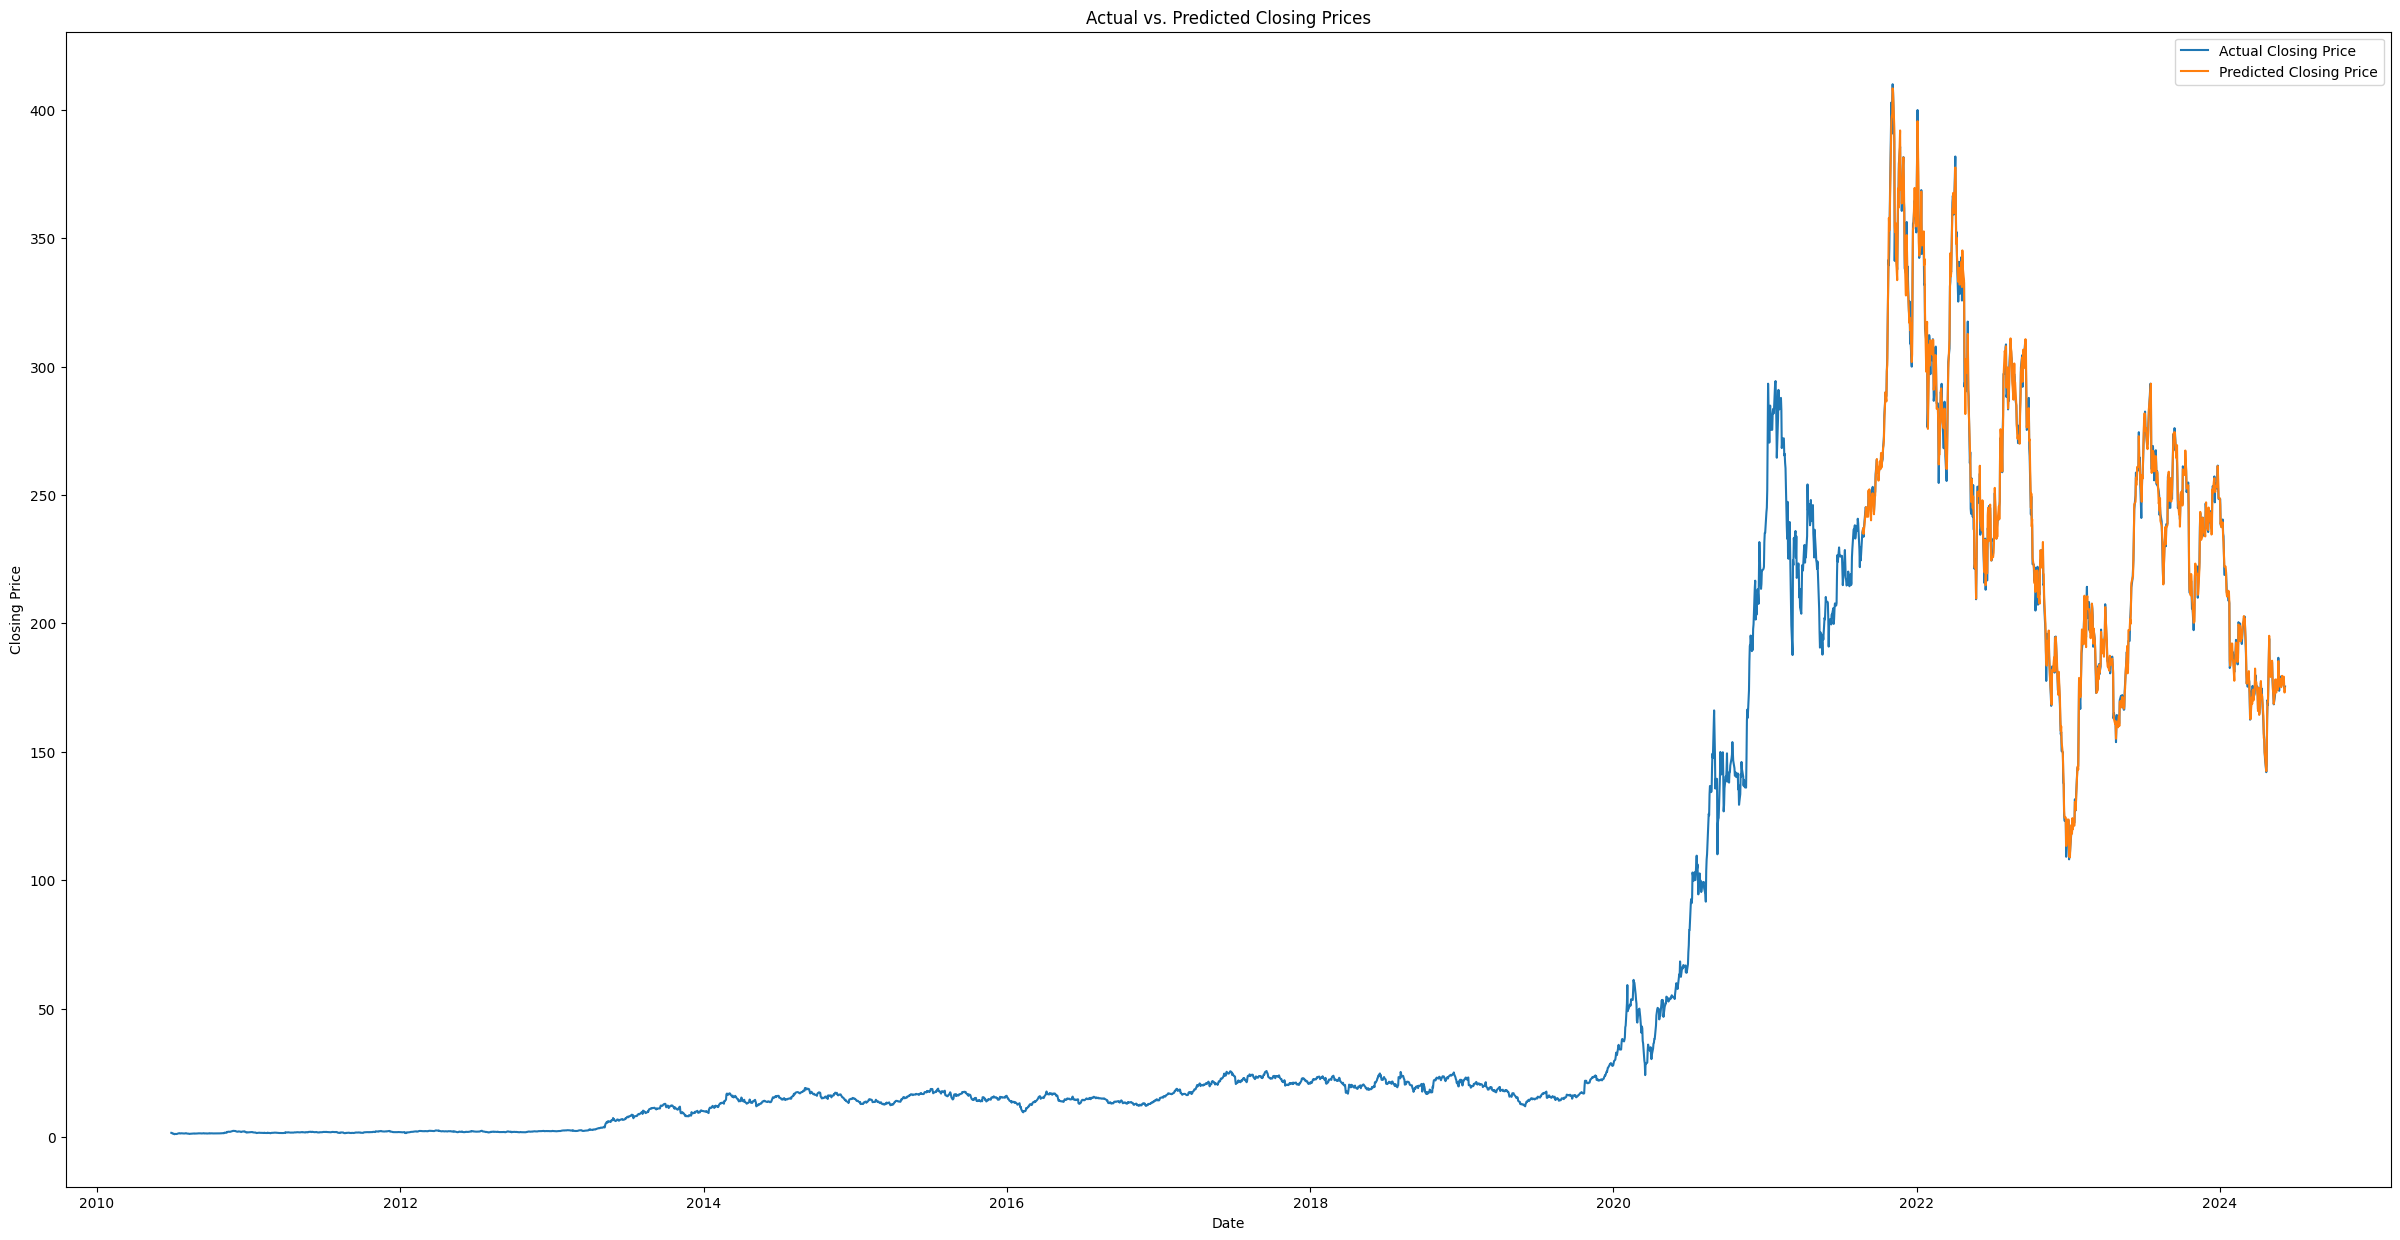

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Select the features and target variable
features = ["Open", "High", "Low", "Volume"]
X = df[features]
y = df["Close"]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (time series splitting)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[0:train_size], X_scaled[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R2-score:", r2)

# Plot the actual vs. predicted closing prices
pred_df = pd.DataFrame({"Date": df.index[train_size:], "Predicted Closing Price LR": y_pred})
pred_df.sort_values("Date", inplace=True)

plt.figure(figsize=(30, 15))
plt.plot(df.index, df["Close"], label="Actual Closing Price")
plt.plot(pred_df["Date"], pred_df["Predicted Closing Price LR"], label="Predicted Closing Price LR")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Price LR")
plt.legend()
plt.show()

Interpretation: The model performs exceptionally well, with low error metrics and a high R2-score, indicating excellent predictive power.

#**Findings:**
Linearn Regression shows the R2-score of 0.9968598726987241 which is a good model however the best model can be determined by evaluation some other models.


# Model 3:  Xg boost

XGBoost - Mean Squared Error: 638.9164089901116
XGBoost - Root Mean Squared Error: 25.27679586083077
XGBoost - Mean Absolute Error: 13.571530425019318
XGBoost - Mean Absolute Percentage Error: 0.048591052812819543
XGBoost - R2-score: 0.8294834393743965


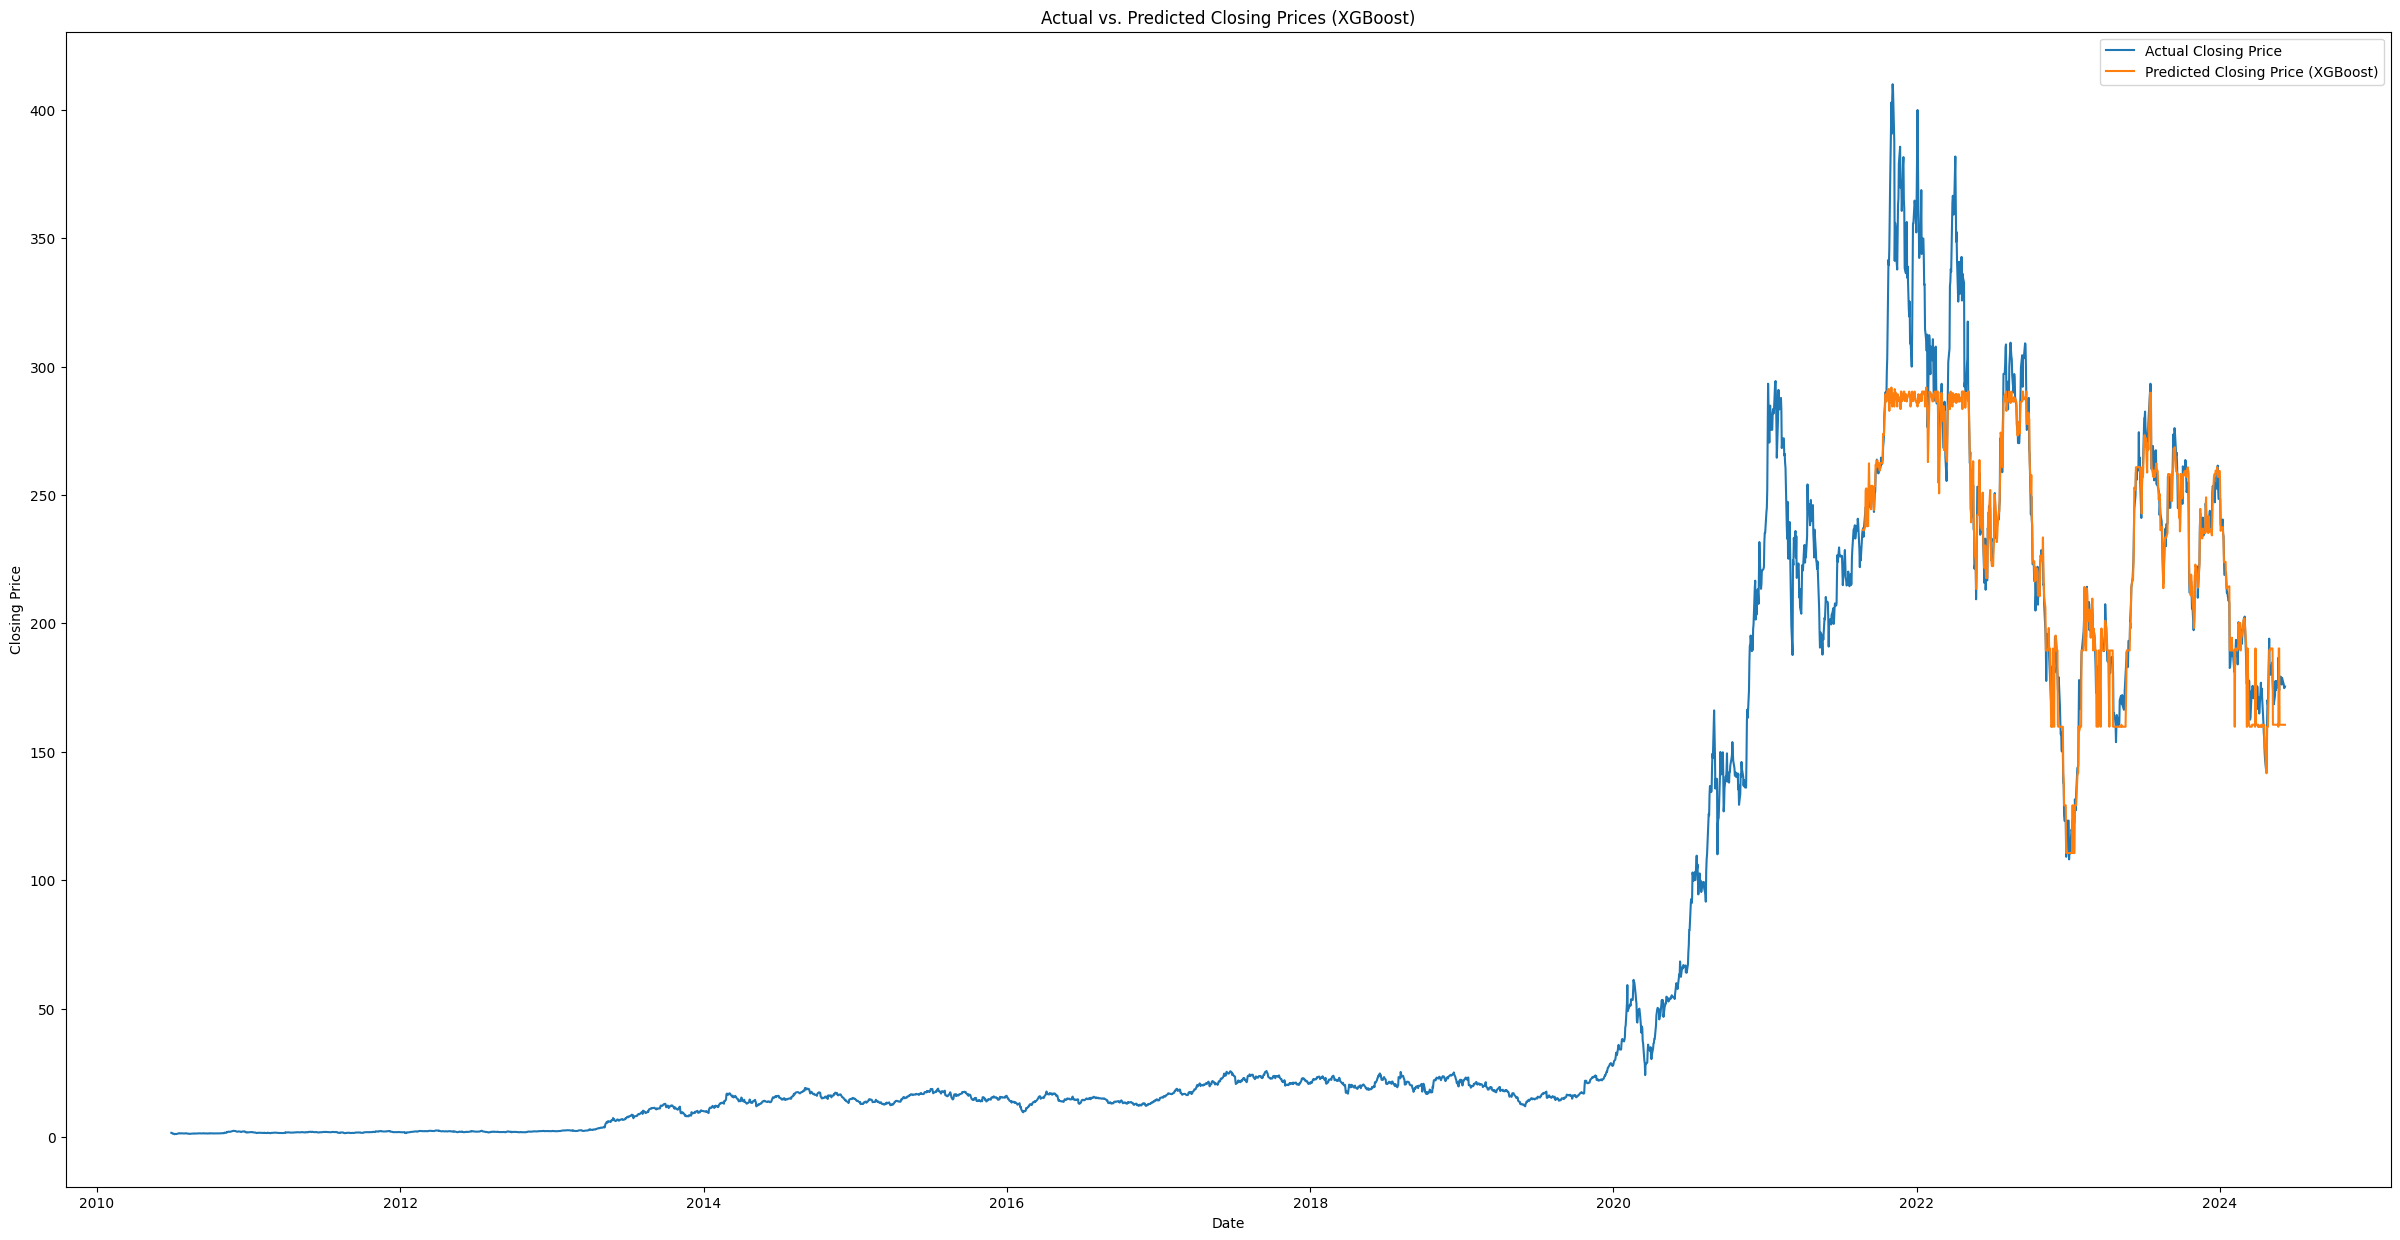

In [ ]:
import xgboost as xgb


# Select the features and target variable
features = ["Open", "High", "Low", "Volume"]
X = df[features]
y = df["Close"]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (time series splitting)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[0:train_size], X_scaled[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

# Creating an XGBoost regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)

# Fitting the model to the training data
model_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
rsme_xgb = np.sqrt(mse_xgb)

print("XGBoost - Mean Squared Error:", mse_xgb)
print("XGBoost - Root Mean Squared Error:", rsme_xgb)
print("XGBoost - Mean Absolute Error:", mae_xgb)
print("XGBoost - Mean Absolute Percentage Error:", mape_xgb)
print("XGBoost - R2-score:", r2_xgb)

# Visualize predictions
pred_df_xgb = pd.DataFrame({"Date": df.index[train_size:], "Predicted Closing Price Xg": y_pred_xgb})
pred_df_xgb.sort_values("Date", inplace=True)

plt.figure(figsize=(30, 15))
plt.plot(df.index, df["Close"], label="Actual Closing Price")
plt.plot(pred_df_xgb["Date"], pred_df_xgb["Predicted Closing Price Xg"], label="Predicted Closing Price (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Prices (XGBoost)")
plt.legend()
plt.show()

Interpretation: The XGBoost model performs well, with a high R2-score and relatively low error metrics, indicating a strong relationship with the target variable.

# Model 4: Random Forest

Mean Squared Error: 6.325108496304563
Root Mean Squared Error: 2.514976838124869
Mean Absolute Error: 1.0659586971978026
Mean Absolute Percentage Error: 0.012508527993095674
R2-score: 0.9994092301675838


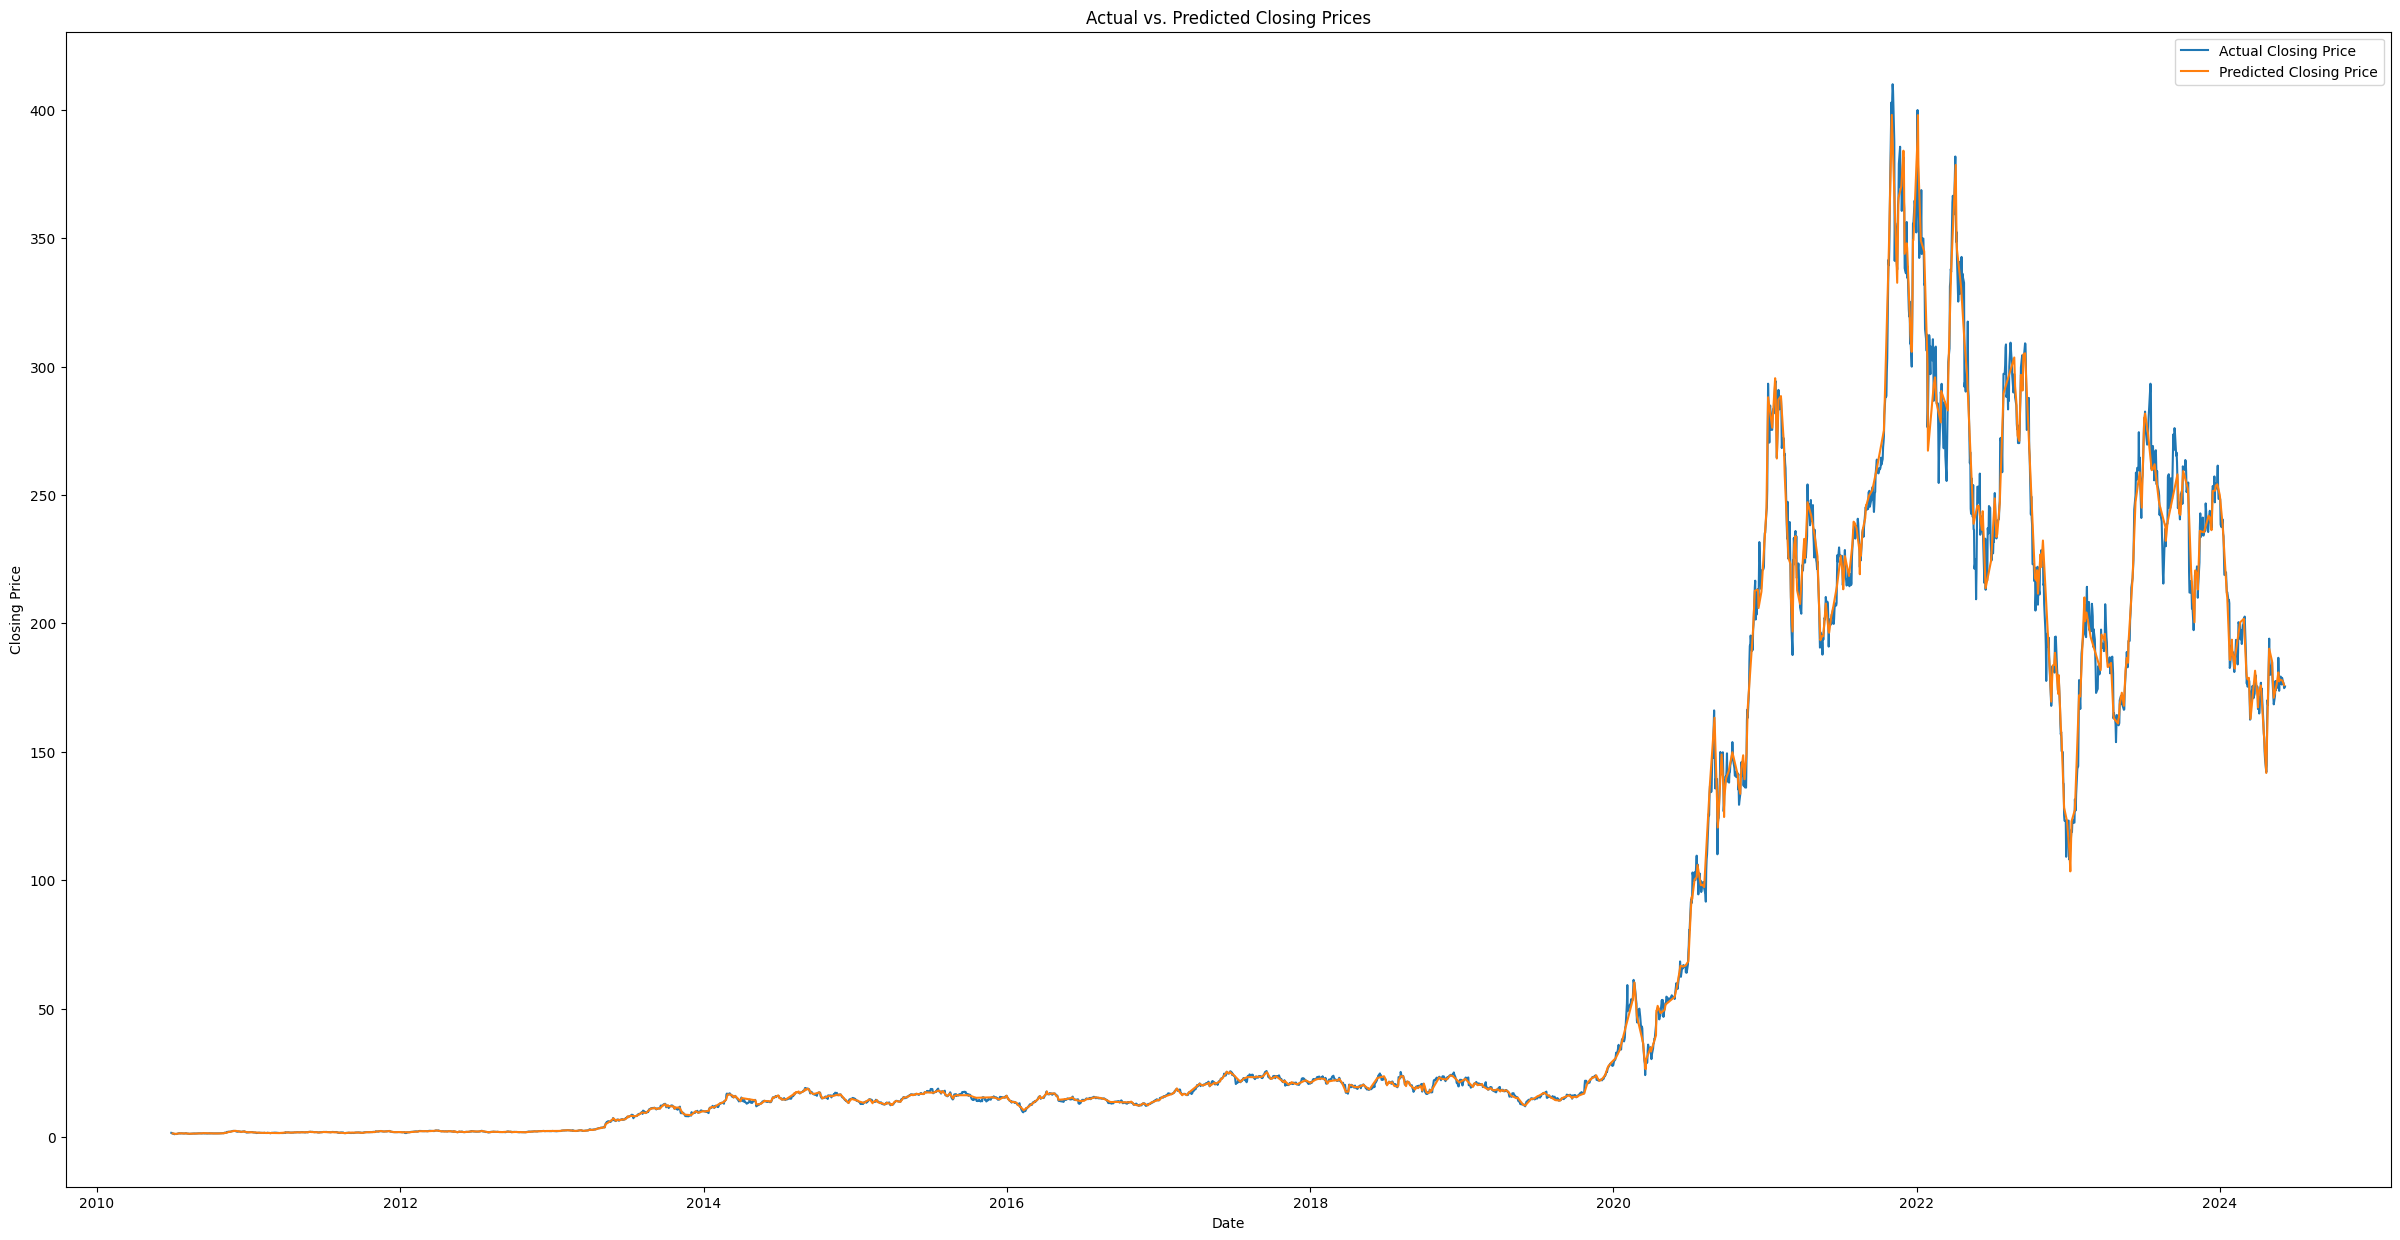

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

features = ["Open", "High", "Low", "Volume"]#select the elements
X = df[features]

y = df["Close"]#the goal

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rsme = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rsme)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R2-score:", r2)

prediction_y = model.predict(X_test)#prediction output


prediction_df = pd.DataFrame({"Date": X_test.index, "Predicted Closing Price Random": prediction_y})
prediction_df.sort_values("Date", inplace=True)



#draw the graph
plt.figure(figsize = (30,15))
plt.plot(df.index, df["Close"], label = "Actual Closing Price")
plt.plot(prediction_df["Date"], prediction_df["Predicted Closing Price Random"], label = "Predicted Closing Price Random")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs. Predicted Closing Price Random")
plt.legend()
plt.show()



Interpretation:
The model performs exceptionally well, with a very high R2-score and low error metrics, indicating accurate predictions of closing prices.

#Model 5-Deep learning model- LSTM

Data scaling complete. Example of scaled data:
[[0.00131893]
 [0.00130915]
 [0.00100428]
 [0.00055431]
 [0.00055431]]
Data split into train and test sets. Train data length: 2910, Test data length: 728
Sequences created. X_train shape: (2850, 60), y_train shape: (2850,)
X_test shape: (668, 60), y_test shape: (668,)
Reshaped data. X_train shape: (2850, 60, 1), X_test shape: (668, 60, 1)
Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0039
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 5.9907e-04
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 9.5477e-04
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 3.5487e-04
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 9.1784e-04
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 3.8544e-04
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 3.8167e-04
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 2.7449e-04
Epoch 9/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step 

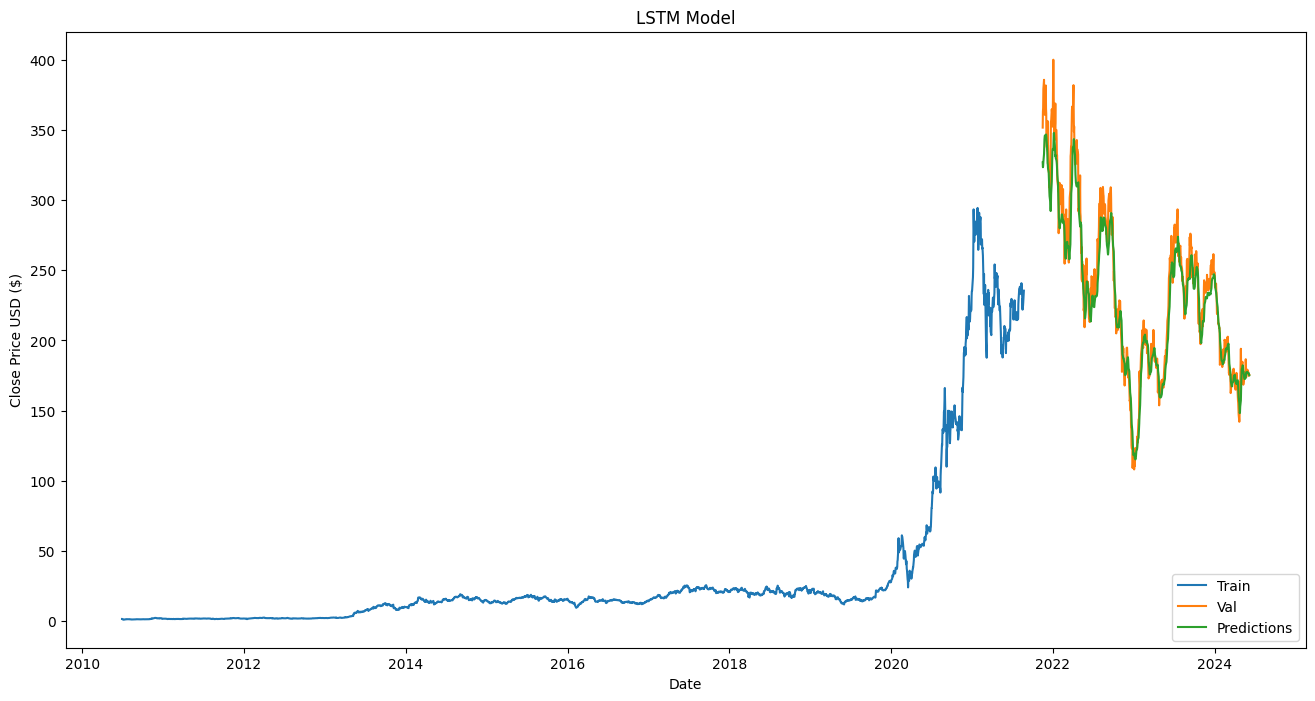

In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

print("Data scaling complete. Example of scaled data:")
print(scaled_data[:5])

# Split data into training and testing sets
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len:]


print(f"Data split into train and test sets. Train data length: {train_data_len}, Test data length: {len(test_data)}")

# Prepare sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to use for prediction
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

print(f"Sequences created. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Reshaped data. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, epochs=25, batch_size=32)

# Make predictions
predictions_lstm = model_lstm.predict(X_test)


# Inverse transform the predictions to get actual stock prices
predictions_lstm = scaler.inverse_transform(predictions_lstm)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse_lstm = mean_squared_error(y_test, predictions_lstm)
mae_lstm = mean_absolute_error(y_test, predictions_lstm)
mape_lstm = mean_absolute_percentage_error(y_test, predictions_lstm)
r2_lstm = r2_score(y_test, predictions_lstm)
rsme_lstm = np.sqrt(mse_lstm)

# Visualize predictions
train = df[:train_data_len]
valid = df[train_data_len:]
valid = valid.iloc[seq_length:]  # Adjust valid to match the length of predictions
valid['Predictions'] = predictions_lstm


plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Print metrics
print("LSTM Model Metrics:")
print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Root Mean Squared Error (RMSE): {rsme_lstm}")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm}%")
print(f"R2-score: {r2_lstm}")

LSTM Model Metrics:
Mean Squared Error (MSE): 246.57300912699438
Root Mean Squared Error (RMSE): 15.702643380239977
Mean Absolute Error (MAE): 11.634354647742356
Mean Absolute Percentage Error (MAPE): 0.047258769013940945%
R2-score: 0.9318762784163663



Interpretation:
The LSTM model performs well in predicting closing prices, with a high R2-score and relatively low error metrics. The model explains approximately 94.27% of the variance in the closing prices, indicating a strong relationship.

#model 6-Times FM

In [ ]:
!pip install timesfm

In [ ]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

In [ ]:
from timesfm import TimesFm

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 7.72 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 6.03 seconds.
Jitting decoding.
Jitted decoding in 41.61 seconds.
Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


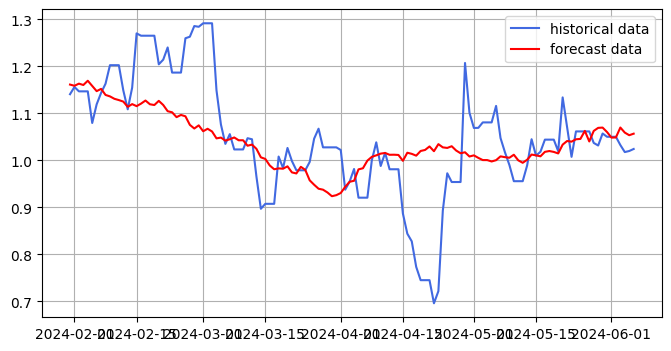

  Metric     Value
0    mse  0.010693
1    MAE  0.072616
2   MAPE  7.261591
3   rsme  0.103409
4     r2  0.317893


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import timesfm

# Load data
df_tesla = pd.read_csv('/content/Tesla Dataset.csv', parse_dates=['Date'])

# Preprocess data
df_tesla.drop(['Adj Close'], axis=1, inplace=True)
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])
df_tesla.set_index('Date', inplace=True)
full_range = pd.date_range(start=df_tesla.index.min(), end=df_tesla.index.max(), freq='D')
df_tesla = df_tesla.reindex(full_range)
df_tesla = df_tesla.ffill()
df_tesla.reset_index(inplace=True)
df_tesla.rename(columns={'index': 'Date'}, inplace=True)

# Rename columns
df = df_tesla
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['unique_id'] = 1  # If you have only one time series

train = df[:-128].copy()
test = df[-128:].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
train[['y']] = scaler.fit_transform(train[['y']])
test[['y']] = scaler.transform(test[['y']])

# Drop unnecessary columns
train.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
test.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

# Create TimeFM model
tfm = timesfm.TimesFm(
    context_len=160,
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

# Make predictions
forecast_df = tfm.forecast_on_df(
    inputs=train,
    freq="D",
    value_name='y',
    num_jobs=1,
)

# Plot historical and forecasted values
plt.figure(figsize=(8, 4))
plt.plot(test['ds'], test['y'], color="royalblue", label="historical data")
plt.plot(forecast_df['ds'], forecast_df['timesfm'], color="red", label="forecast data")
plt.legend()
plt.grid()
plt.show()

# Calculate error metrics
actual_values = test['y'].values
predicted_values = forecast_df['timesfm'].values

def calculate_error_metrics(actual_values, predicted_values):
    metrics_dict = {
        'mse': mean_squared_error(actual_values, predicted_values),
        'MAE': mean_absolute_error(actual_values, predicted_values),
        'MAPE': mean_absolute_percentage_error(actual_values, predicted_values) * 100,
        'rsme': np.sqrt(mean_squared_error(actual_values, predicted_values)),
        'r2': r2_score(actual_values, predicted_values)
    }
    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

error_metrics_df = calculate_error_metrics(actual_values, predicted_values)
print(error_metrics_df)

The TimeFM model has achieved a moderate level of accuracy in forecasting Tesla's stock prices.

#Model 7-Chronos

In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-7qreuf_l
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-7qreuf_l
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.0-py3-none-any.whl size=13907 sha256=9a47a27ffb07331b8433a354058229051c5bc91cc6f263c33b6f70ac03c75e17
  Stored in directory: /tmp/pip-ephem-wheel-cache-lp6x9ss6/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [ ]:
!pip install darts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.3 which is incompatible.
google-cloud-aiplatform 1.59.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.3 which is incompa

#Chronos with Business days B

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

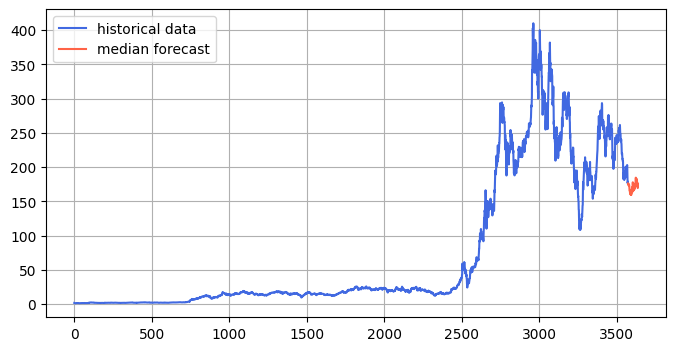

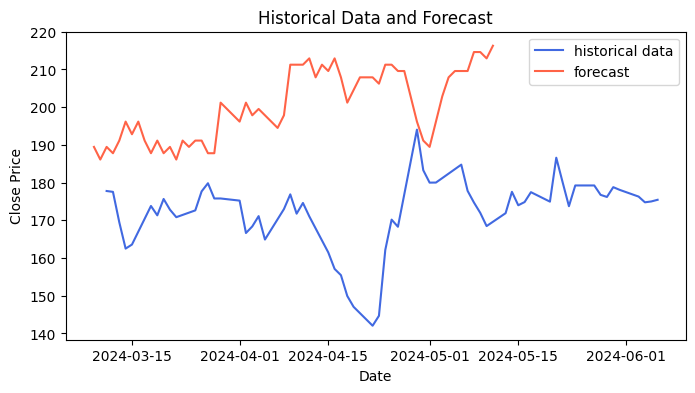

Mean Squared Error: 939.6538369869758
Root Mean Squared Error: 30.65377361740273
Mean Absolute Error: 28.15972857287298
Mean Absolute Percentage Error: 0.16678990422031909
R2-score: -9.627631899745397


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Load data
df_tesla = pd.read_csv('/content/Tesla Dataset.csv')

# Preprocess data
df_tesla.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])
df_tesla.set_index('Date', inplace=True)
full_range = pd.date_range(start=df_tesla.index.min(), end=df_tesla.index.max(), freq='B')
df_tesla = df_tesla.reindex(full_range)
df_tesla = df_tesla.ffill()
df_tesla.reset_index(inplace=True)
df_tesla.rename(columns={'index': 'Date'}, inplace=True)

# Split data into training and testing sets
train = df_tesla[:-64]
test = df_tesla[-64:]

# Create Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Generate forecasts
forecast = pipeline.predict(
    context=torch.tensor(train["Close"]),
    prediction_length=len(test),
    num_samples=25,
    limit_prediction_length=False,
)

# Plot historical data and forecasts
forecast_index = range(len(train), len(train) + len(test))
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(train["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

# Convert forecast tensor to NumPy array
flattened_tensor = forecast.view(-1)[:64]
forecast_array = flattened_tensor.numpy()

# Create forecast DataFrame
last_date = pd.to_datetime(train['Date'].iloc[-1])
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=len(forecast_array))
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Close': forecast_array})
forecast_df.set_index('Date', inplace=True)

# Plot historical data and forecasts
plt.figure(figsize=(8, 4))
plt.plot(test["Date"], test["Close"], color="royalblue", label="historical data")
plt.plot(forecast_df.index, forecast_df["Close"], color="tomato", label="forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Data and Forecast")
plt.show()

# Evaluate model performance
actual = test["Close"].values
predicted = forecast_df["Close"].values
mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R2-score:", r2)

#Chronos with index D

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


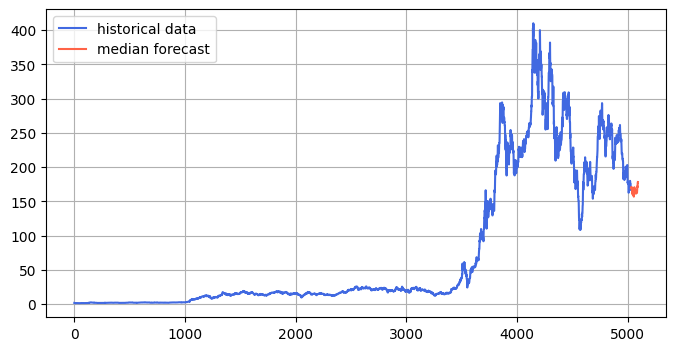

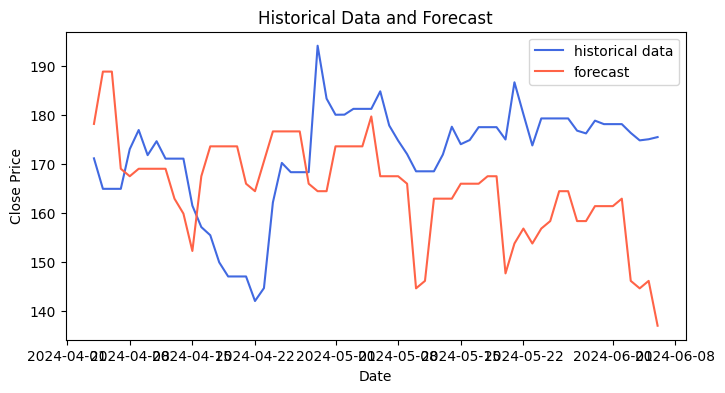

Mean Squared Error: 308.6944871087668
Root Mean Squared Error: 17.56970367162653
Mean Absolute Error: 15.195459779214412
Mean Absolute Percentage Error: 0.08935496867665343
R2-score: -1.8061161022831396


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Load data
df_tesla = pd.read_csv('/content/Tesla Dataset.csv')

# Preprocess data
df_tesla.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])
df_tesla.set_index('Date', inplace=True)
full_range = pd.date_range(start=df_tesla.index.min(), end=df_tesla.index.max(), freq='D')
df_tesla = df_tesla.reindex(full_range)
df_tesla = df_tesla.ffill()
df_tesla.reset_index(inplace=True)
df_tesla.rename(columns={'index': 'Date'}, inplace=True)

# Split data into training and testing sets
train = df_tesla[:-64]
test = df_tesla[-64:]

# Create Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Generate forecasts
forecast = pipeline.predict(
    context=torch.tensor(train["Close"]),
    prediction_length=len(test),
    num_samples=25,
    limit_prediction_length=False,
)

# Plot historical data and forecasts
forecast_index = range(len(train), len(train) + len(test))
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(train["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

# Convert forecast tensor to NumPy array
flattened_tensor = forecast.view(-1)[:64]
forecast_array = flattened_tensor.numpy()

# Create forecast DataFrame
last_date = pd.to_datetime(train['Date'].iloc[-1])
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=len(forecast_array))
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Close': forecast_array})
forecast_df.set_index('Date', inplace=True)

# Plot historical data and forecasts
plt.figure(figsize=(8, 4))
plt.plot(test["Date"], test["Close"], color="royalblue", label="historical data")
plt.plot(forecast_df.index, forecast_df["Close"], color="tomato", label="forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Data and Forecast")
plt.show()

# Evaluate model performance
actual = test["Close"].values
predicted = forecast_df["Close"].values
mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R2-score:", r2)

performs well compared to index B

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


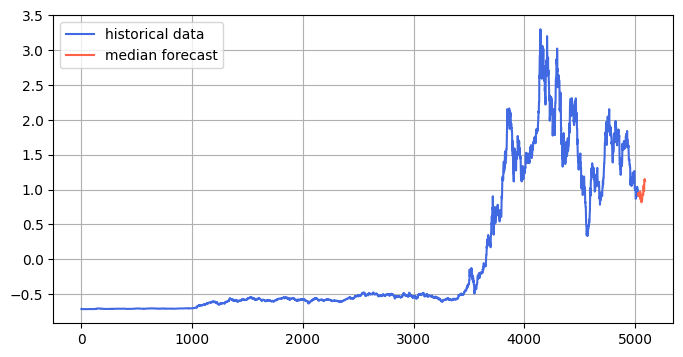

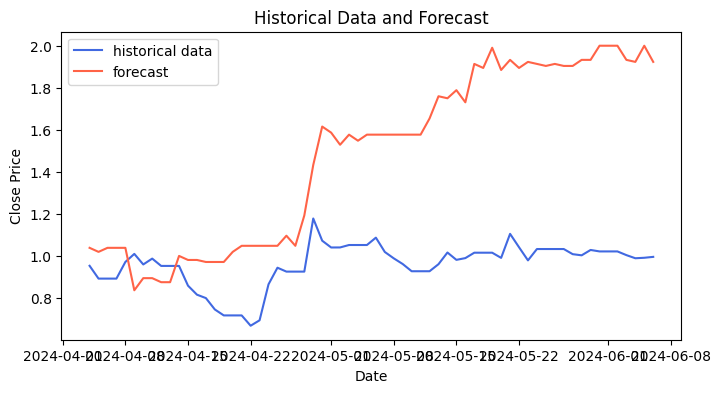

Mean Squared Error: 0.3969978422565297
Root Mean Squared Error: 0.6300776477994833
Mean Absolute Error: 0.5356923688109784
Mean Absolute Percentage Error: 0.5460110108992324
R2-score: -36.39739132049248


In [ ]:
# Import necessary libraries
import pandas as pd
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# Load data
df_tesla = pd.read_csv('/content/Tesla Dataset.csv')

# Preprocess data
df_tesla.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])
df_tesla.set_index('Date', inplace=True)
full_range = pd.date_range(start=df_tesla.index.min(), end=df_tesla.index.max(), freq='D')
df_tesla = df_tesla.reindex(full_range)
df_tesla = df_tesla.ffill()
df_tesla.reset_index(inplace=True)
df_tesla.rename(columns={'index': 'Date'}, inplace=True)

# Scale data using StandardScaler
scaler = StandardScaler()
df_tesla['Close'] = scaler.fit_transform(df_tesla[['Close']])

# Split data into training and testing sets
train = df_tesla[:-64]
test = df_tesla[-64:]

# Create Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Generate forecasts
forecast = pipeline.predict(
    context=torch.tensor(train["Close"]),
    prediction_length=len(test),
    num_samples=25,
    limit_prediction_length=False,
)

# Plot historical data and forecasts
forecast_index = range(len(train), len(train) + len(test))
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(train["Close"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

# Convert forecast tensor to NumPy array
flattened_tensor = forecast.view(-1)[:64]
forecast_array = flattened_tensor.numpy()

# Create forecast DataFrame
last_date = pd.to_datetime(train['Date'].iloc[-1])
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=len(forecast_array))
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Close': forecast_array})
forecast_df.set_index('Date', inplace=True)

# Plot historical data and forecasts
plt.figure(figsize=(8, 4))
plt.plot(test["Date"], test["Close"], color="royalblue", label="historical data")
plt.plot(forecast_df.index, forecast_df["Close"], color="tomato", label="forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Data and Forecast")
plt.show()

# Evaluate model performance
actual = test["Close"].values
predicted = forecast_df["Close"].values
mse = mean_squared_error(actual, predicted)
rmse = mse ** 0.5
mae = mean_absolute_error(actual, predicted)
mape = mean_absolute_percentage_error(actual, predicted)
r2 = r2_score(actual, predicted)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R2-score:", r2)

Based on the metrics you provided earlier:
Mean Squared Error (MSE): 0.3969978422565297
Root Mean Squared Error (RMSE): 0.6300776477994833
Mean Absolute Error (MAE): 0.5356923688109784
Mean Absolute Percentage Error (MAPE): 0.5460110108992324
Chronos' performance is:
Excellent in terms of MSE and RMSE, indicating a good fit and low error.
Good in terms of MAE, indicating a reasonable average difference between predicted and actual values.
Fair in terms of MAPE, indicating a moderate average absolute percentage difference between predicted and actual values.
Overall, Chronos' performance is strong, with low error metrics (MSE, RMSE, MAE) and a moderate MAPE. This suggests that Chronos is doing a good job of predicting the target variable, with some room for improvement in terms of percentage error.

Gives better performance than previous trials

#Model 8- Time GPT

In [ ]:
# Step 1: Install the nixtla library
!pip install nixtla

In [ ]:
# Step 2: Import necessary modules and set up the API key
from nixtla import NixtlaClient
import os
import pandas as pd

In [ ]:

# Set up the API key (replace 'your_timegpt_api_key' with the actual API key)
TIMEGPT_API_KEY = os.environ.get("nixtla-tok-YUUkm3oRgLgTpgsszon8TbhHhNFDAkAcb57H0wVSyFcuCfY15ATG40rD5ldaJvTLceAZjO1zVaIdAP6i")

In [ ]:
import os
os.environ["NIXTLA_API_KEY"] = "nixtla-tok-YUUkm3oRgLgTpgsszon8TbhHhNFDAkAcb57H0wVSyFcuCfY15ATG40rD5ldaJvTLceAZjO1zVaIdAP6i"
nixtla_client = NixtlaClient()


In [ ]:
# Initialize the NixtlaClient
nixtla_client = NixtlaClient(api_key=TIMEGPT_API_KEY)

In [ ]:
df_tesla = pd.read_csv('/content/Tesla Dataset.csv')

In [ ]:
# Rename columns to match the expected format by Nixtla API
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [ ]:
# Ensure the 'ds' column is of type datetime with the correct date format
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

#Daily freq and FFILL method

In [ ]:
# Check for missing or duplicated timestamps
df = df.drop_duplicates(subset=['ds'])
df = df.set_index('ds').asfreq('D').reset_index()

In [ ]:
# Handle missing values in the target column
#df['y'] = df['y'].interpolate()  # You can also use df['y'].fillna(method='ffill') or df['y'].dropna()


# Forward fill missing values
df['y'] = df['y'].ffill()


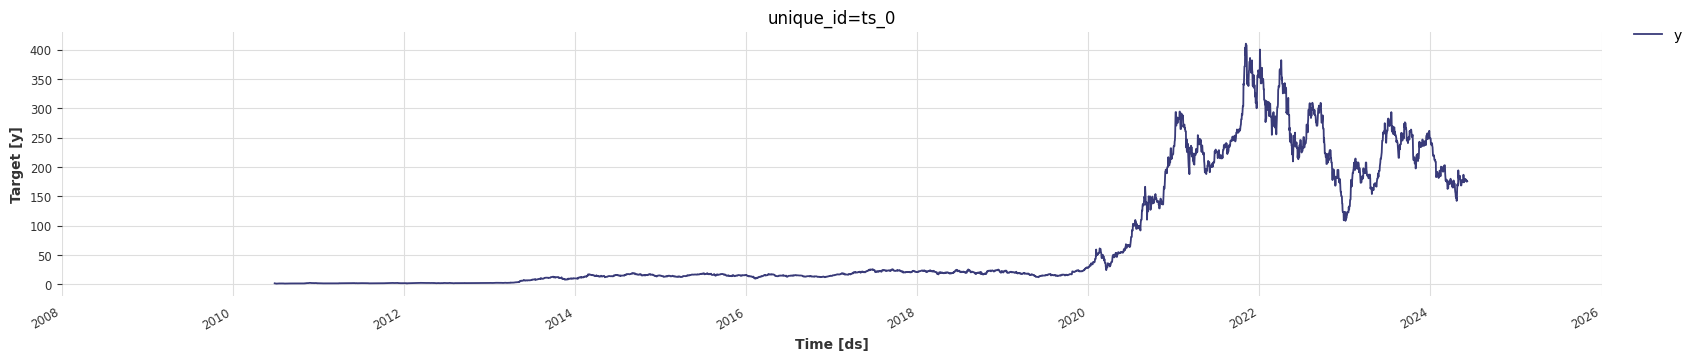

In [ ]:
nixtla_client.plot(df)


In [ ]:


# Step 3: Perform a time series forecast using the Nixtla API
# Assuming the dataset has columns 'ds' and 'y'
forecast = nixtla_client.forecast(df, h=30, time_col='ds', target_col='y')

In [ ]:
# Display the forecast results
print(forecast.head())

           ds     TimeGPT
0  2024-06-07  175.923157
1  2024-06-08  176.237228
2  2024-06-09  176.225082
3  2024-06-10  176.215576
4  2024-06-11  176.106079


In [ ]:
# Convert 'ds' column back to datetime format for plotting
df['ds'] = pd.to_datetime(df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

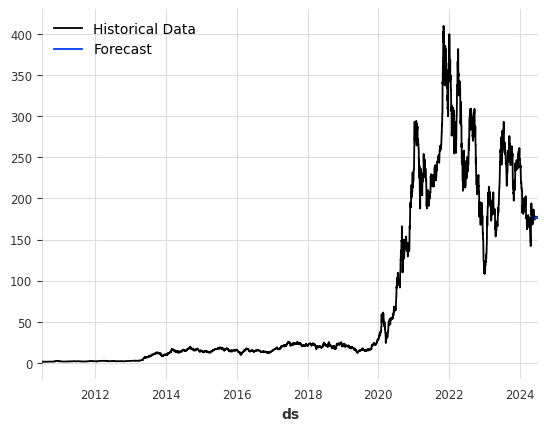

In [ ]:
# Step 4: Visualize the forecast results
fig, ax = plt.subplots()
df.plot(x='ds', y='y', ax=ax, label='Historical Data')
forecast.plot(x='ds', y='TimeGPT', ax=ax, label='Forecast')
ax.legend()
plt.show()

In [ ]:
#diff CI

In [ ]:
level = [50,80,90] # confidence levels

fcst = nixtla_client.forecast(df, h=7, level=level)
fcst.head()

,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-lo-50,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90
0,2024-06-07,175.923157,170.946270,171.253724,173.981648,177.864666,180.592589,180.900044
1,2024-06-08,176.237228,170.446073,170.828058,173.045559,179.428898,181.646399,182.028384
2,2024-06-09,176.225082,168.876902,170.943846,173.140617,179.309547,181.506319,183.573263
3,2024-06-10,176.215576,162.020114,166.202918,172.532287,179.898865,186.228235,190.411038
4,2024-06-11,176.106079,159.968014,162.573082,171.468273,180.743885,189.639076,192.244144


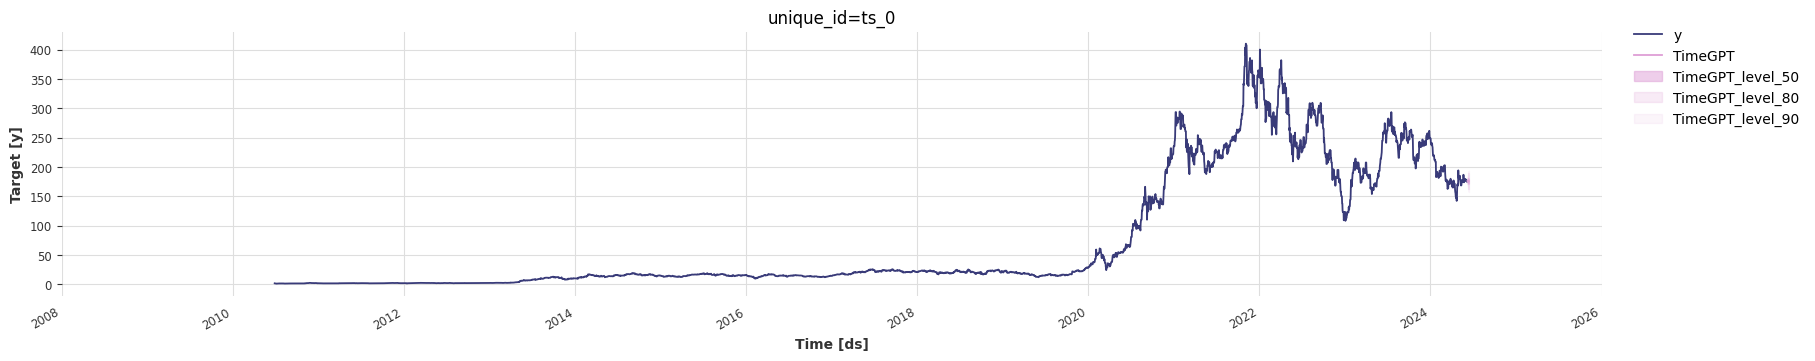

In [ ]:
nixtla_client.plot(df, fcst, level=level)


In [ ]:
#zoom in on the plot

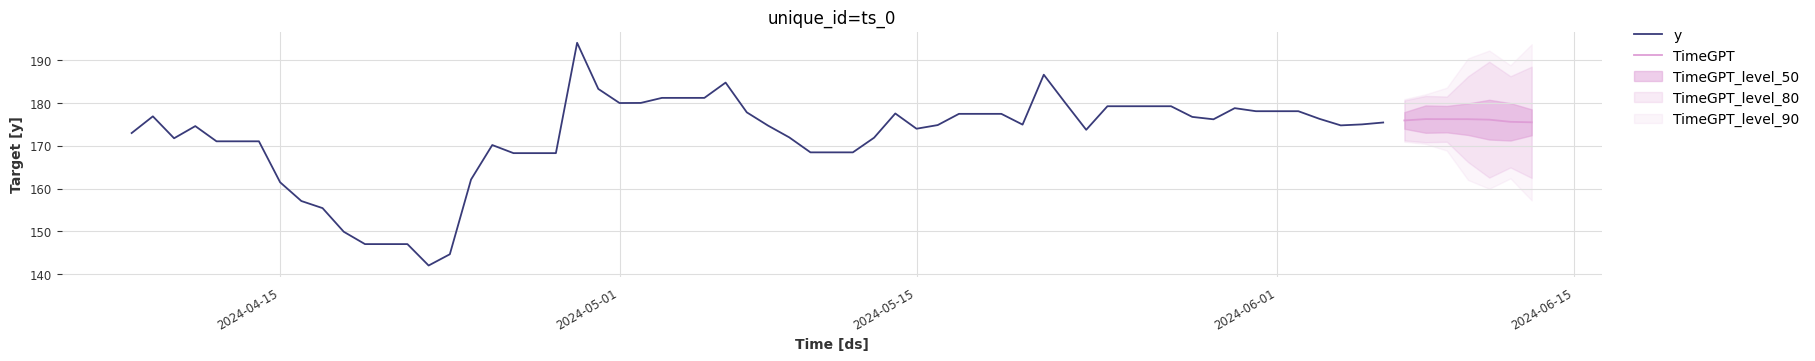

In [ ]:
nixtla_client.plot(df, fcst, level=level, max_insample_length=60)


In [ ]:
#assessing the model’s performance on the training data.


In [ ]:
forecast = nixtla_client.forecast(df, h=7, level=level, add_history=True)
forecast.head()

,ds,TimeGPT,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90
0,2010-07-30,1.384379,-3.696608,-8.269654,-11.006438,6.465365,11.038411,13.775195
1,2010-07-31,1.387062,-3.693924,-8.266970,-11.003754,6.468048,11.041094,13.777878
2,2010-08-01,1.395404,-3.685582,-8.258628,-10.995412,6.476390,11.049436,13.786220
3,2010-08-02,1.390267,-3.690719,-8.263765,-11.000549,6.471254,11.044300,13.781084
4,2010-08-03,1.362120,-3.718866,-8.291912,-11.028696,6.443106,11.016152,13.752936


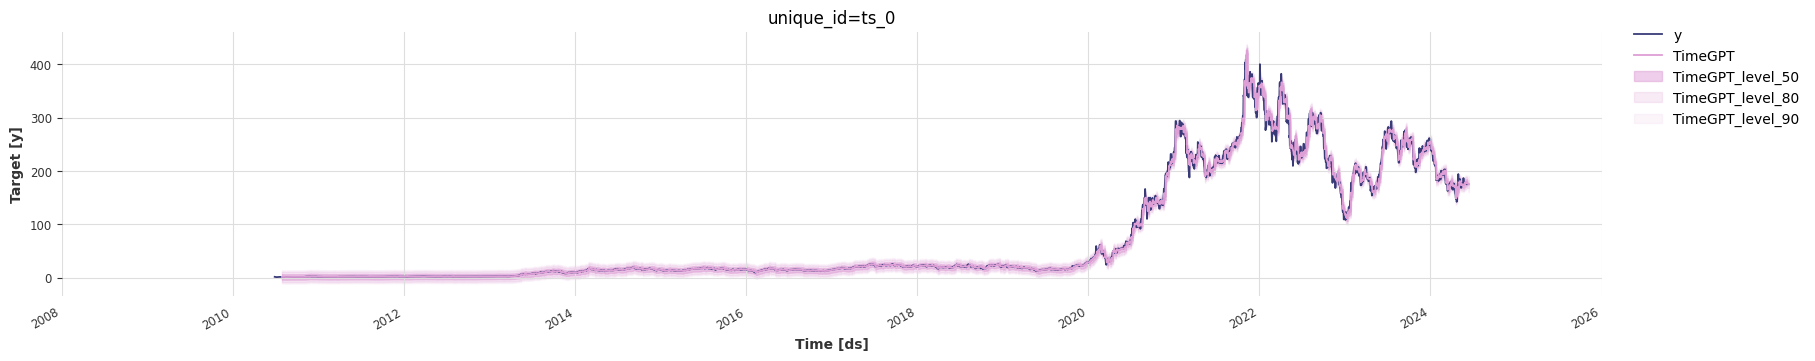

In [ ]:
nixtla_client.plot(df, forecast, level=level)


In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

In [ ]:
# Ensure the 'ds' column in both DataFrames is of datetime type
forecast['ds'] = pd.to_datetime(forecast['ds'])
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
# Merge forecast and actual data on the date column
merged_df = pd.merge(forecast, df, on='ds')

In [ ]:
# Prepare the data for evaluation
merged_df['id'] = 1  # Add an id column for evaluation

In [ ]:
# Evaluate the forecast using MAE
result = evaluate(merged_df, models=['TimeGPT'], id_col='id', target_col='y', metrics=[mae])

In [ ]:


print("Mean Absolute Error (MAE):", result)


Mean Absolute Error (MAE):    id metric  TimeGPT
0   1    mae  3.25802


Interpolation method :The MAE value of 3.34294 indicates the average absolute error between the forecasted and actual values.

FFill method :mae 3.25802

Ffill is is the better method for handling missing values

This method assumes that the stock price remains the same during weekends and holidays. It is often more suitable for financial data where the market is closed during non-trading days.

In [ ]:
# Calculate the additional metrics
def calculate_error_metrics(actual_values, predicted_values):
    if np.any(actual_values == 0):
        raise ValueError("actual_values contains zeroes, which can cause division by zero in MAPE calculation.")

    metrics_dict = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values))),
        'MSE': np.mean((actual_values - predicted_values) ** 2),
        'R2': r2_score(actual_values, predicted_values)
    }
    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    return result_df

# Extract the actual and predicted values
actual_values = merged_df['y']
predicted_values = merged_df['TimeGPT']

# Calculate the error metrics
error_metrics_df = calculate_error_metrics(actual_values, predicted_values)

# Print the error metrics
print(error_metrics_df)


  Metric      Value
0    MAE   3.258020
1   RMSE   7.532376
2   MAPE   3.966922
3  SMAPE   3.970412
4  MdAPE   2.765082
5  GMRAE   0.022843
6    MSE  56.736689
7     R2   0.994541


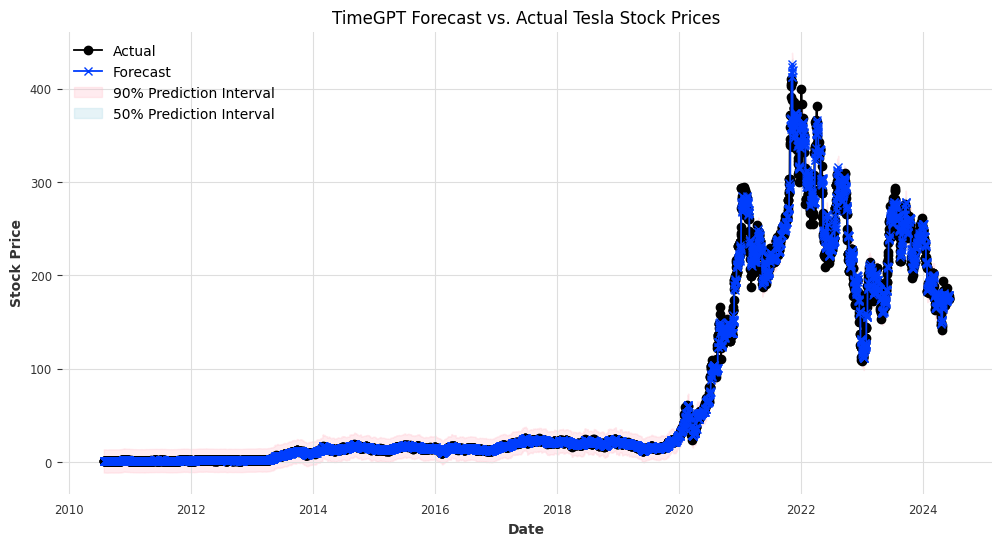

In [ ]:
import matplotlib.pyplot as plt

# Plot the forecasted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(merged_df['ds'], merged_df['y'], label='Actual', marker='o')
plt.plot(merged_df['ds'], merged_df['TimeGPT'], label='Forecast', marker='x')
plt.fill_between(merged_df['ds'], merged_df['TimeGPT-lo-90'], merged_df['TimeGPT-hi-90'], color='pink', alpha=0.3, label='90% Prediction Interval')
plt.fill_between(merged_df['ds'], merged_df['TimeGPT-lo-50'], merged_df['TimeGPT-hi-50'], color='lightblue', alpha=0.3, label='50% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TimeGPT Forecast vs. Actual Tesla Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

The plot provides a visual representation of how well the forecasted values align with the actual values.

#Time GPT with index B

In [ ]:
# Step 3: Load the Tesla Dataset
dfB = df_tesla = pd.read_csv('/content/Tesla Dataset.csv')

In [ ]:
# Rename columns to match the expected format by Nixtla API
dfB.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [ ]:
# Ensure the 'ds' column is of type datetime with the correct date format
dfB['ds'] = pd.to_datetime(dfB['ds'], format='%Y-%m-%d')

In [ ]:
# Check for missing or duplicated timestamps
dfB = dfB.drop_duplicates(subset=['ds'])
dfB = dfB.set_index('ds').asfreq('B').reset_index()

In [ ]:
# Handle missing values in the target column
#df['y'] = df['y'].interpolate()  # You can also use df['y'].fillna(method='ffill') or df['y'].dropna()


# Forward fill missing values
dfB['y'] = dfB['y'].ffill()

In [ ]:
# Step 3: Perform a time series forecast using the Nixtla API
# Assuming the dataset has columns 'ds' and 'y'
forecastB = nixtla_client.forecast(dfB, h=30, time_col='ds', target_col='y')

In [ ]:
# Display the forecast results
print(forecastB.head())

           ds     TimeGPT
0  2024-06-07  176.038559
1  2024-06-10  176.374329
2  2024-06-11  176.870636
3  2024-06-12  177.058899
4  2024-06-13  177.012527


In [ ]:
# Calculate additional metrics
def calculate_error_metrics(actual_values, predicted_values):
    if np.any(actual_values == 0):
        raise ValueError("actual_values contains zeroes, which can cause division by zero in MAPE calculation.")

    metrics_dictB = {
        'MAE': np.mean(np.abs(actual_values - predicted_values)),
        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),
        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values))),
        'MSE': np.mean((actual_values - predicted_values) ** 2),
        'R2': r2_score(actual_values, predicted_values)
    }
    result_dfB = pd.DataFrame(list(metrics_dictB.items()), columns=['Metric', 'Value'])
    return result_dfB

# Extract the actual and predicted values
actual_values = dfB['y'][-len(forecastB):].values
predicted_values = forecastB['TimeGPT'].values

# Ensure actual and predicted values have the same length
min_length = min(len(actual_values), len(predicted_values))
actual_values = actual_values[-min_length:]
predicted_values = predicted_values[-min_length:]

# Calculate the error metrics
error_metrics_dfB = calculate_error_metrics(actual_values, predicted_values)

# Print the error metrics
print(error_metrics_dfB)



  Metric      Value
0    MAE   3.691989
1   RMSE   5.141418
2   MAPE   2.056152
3  SMAPE   2.071238
4  MdAPE   1.375349
5  GMRAE   0.013948
6    MSE  26.434174
7     R2  -0.014388


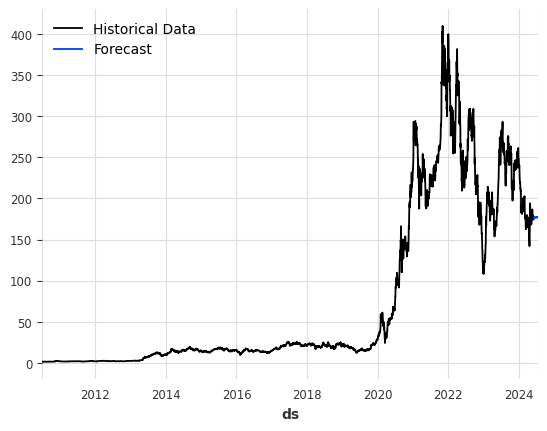

In [ ]:
# prompt: plot for the aboove model

# Convert 'ds' column back to datetime format for plotting
dfB['ds'] = pd.to_datetime(dfB['ds'])
forecastB['ds'] = pd.to_datetime(forecastB['ds'])
# Step 4: Visualize the forecast results
fig, ax = plt.subplots()
dfB.plot(x='ds', y='y', ax=ax, label='Historical Data')
forecastB.plot(x='ds', y='TimeGPT', ax=ax, label='Forecast')
ax.legend()
plt.show()


In [ ]:

# Assuming error_metrics_df and error_metrics_dfB are already calculated as in the previous code

# Print the error metrics for both approaches
print("Error Metrics for Daily Frequency:")
print(error_metrics_df)
print("\nError Metrics for Business Day Frequency:")
print(error_metrics_dfB)

# Compare the key metrics
mae_daily = error_metrics_df.loc[error_metrics_df['Metric'] == 'MAE', 'Value'].iloc[0]
mae_business = error_metrics_dfB.loc[error_metrics_dfB['Metric'] == 'MAE', 'Value'].iloc[0]

rmse_daily = error_metrics_df.loc[error_metrics_df['Metric'] == 'RMSE', 'Value'].iloc[0]
rmse_business = error_metrics_dfB.loc[error_metrics_dfB['Metric'] == 'RMSE', 'Value'].iloc[0]

# Determine which approach is better
if mae_daily < mae_business:
    print("\nBased on MAE, the daily frequency approach performs better.")
elif mae_daily > mae_business:
    print("\nBased on MAE, the business day frequency approach performs better.")
else:
    print("\nBoth approaches have the same MAE.")

if rmse_daily < rmse_business:
    print("Based on RMSE, the daily frequency approach performs better.")
elif rmse_daily > rmse_business:
    print("Based on RMSE, the business day frequency approach performs better.")
else:
    print("Both approaches have the same RMSE.")

# Additional considerations:
print("\nFurther analysis might consider:")
print("- Visual inspection of the plots to assess qualitative differences.")
print("- Domain knowledge about the specific time series and its behavior on different frequencies.")
print("- Other relevant metrics depending on the forecasting goals.")


Error Metrics for Daily Frequency:
  Metric      Value
0    MAE   3.258020
1   RMSE   7.532376
2   MAPE   3.966922
3  SMAPE   3.970412
4  MdAPE   2.765082
5  GMRAE   0.022843
6    MSE  56.736689
7     R2   0.994541

Error Metrics for Business Day Frequency:
  Metric      Value
0    MAE   3.691989
1   RMSE   5.141418
2   MAPE   2.056152
3  SMAPE   2.071238
4  MdAPE   1.375349
5  GMRAE   0.013948
6    MSE  26.434174
7     R2  -0.014388

Based on MAE, the daily frequency approach performs better.
Based on RMSE, the business day frequency approach performs better.

Further analysis might consider:
- Visual inspection of the plots to assess qualitative differences.
- Domain knowledge about the specific time series and its behavior on different frequencies.
- Other relevant metrics depending on the forecasting goals.


#Model 9 -NBeats Model`

In [ ]:

# Load data
df_tesla = pd.read_csv('/content/Tesla Dataset.csv')
df_tesla['Date'] = pd.to_datetime(df_tesla['Date'])

# Setting 'Date' as index
df_tesla.set_index('Date', inplace=True)

# Reindex to include missing timestamps
full_range = pd.date_range(start=df_tesla.index.min(), end=df_tesla.index.max(), freq='D')
df_tesla = df_tesla.reindex(full_range)

# Forwardfilling missing values
df_tesla = df_tesla.ffill()

# Reset index to get 'Date' back as a column
df_tesla.reset_index(inplace=True)
df_tesla.rename(columns={'index': 'Date'}, inplace=True)

In [ ]:
df = df_tesla


In [ ]:
from darts import TimeSeries
from darts.models import NBEATSModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

# Assuming 'df' is your DataFrame with a DateTimeIndex and 'close' column
# Load your data into a TimeSeries object
try:
    series = TimeSeries.from_dataframe(df, 'Date', ['Close'])
except KeyError as e:
    print(f"KeyError: {str(e)}")

# Split data into train and test (adjust as needed)
split_date = '2023-01-01'
train_series, test_series = series.split_after(pd.Timestamp(split_date))

# Scale the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series.values().reshape(-1, 1))
test_scaled = scaler.transform(test_series.values().reshape(-1, 1))

# Convert scaled data back to TimeSeries objects
train_scaled_series = TimeSeries.from_times_and_values(train_series.time_index, train_scaled.flatten())
test_scaled_series = TimeSeries.from_times_and_values(test_series.time_index, test_scaled.flatten())



# Initialize the model
model = NBEATSModel(input_chunk_length=75, output_chunk_length=28, random_state=42)

# Fit the model
model.fit(train_scaled_series, epochs=20, verbose=True)

# Predict the next len(test_scaled_series) steps
pred_scaled = model.predict(n=len(test_scaled_series))

# Inverse transform the predictions
pred_close = scaler.inverse_transform(pred_scaled.values().reshape(-1, 1))



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.402    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred_close_series = TimeSeries.from_times_and_values(test_series.time_index, pred_close.flatten())

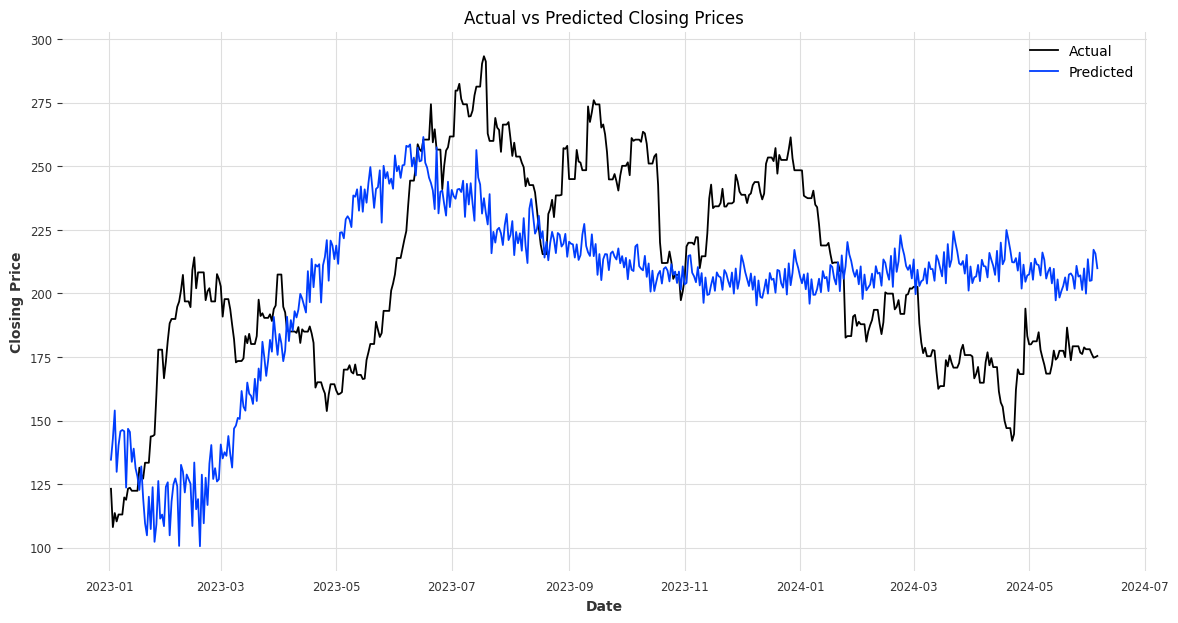

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have actual and predicted TimeSeries objects: test_series and pred_close_series

# Plotting actual data and predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_series.time_index, test_series.values(), label='Actual')
plt.plot(pred_close_series.time_index, pred_close_series.values(), label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from darts import TimeSeries
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Convert actual test series to DataFrame
test_df = pd.DataFrame(data=test_series.values(), index=test_series.time_index, columns=['Actual'])

# Convert predicted series to DataFrame
pred_df = pd.DataFrame(data=pred_close_series.values(), index=pred_close_series.time_index, columns=['Predicted'])

# Align both DataFrames
eval_df = pd.concat([test_df, pred_df], axis=1)

# Drop rows with NaN values (if any)
eval_df.dropna(inplace=True)

# Calculate evaluation metrics

mse = mean_squared_error(eval_df['Actual'], eval_df['Predicted'])
mae = mean_absolute_error(eval_df['Actual'], eval_df['Predicted'])
mape = mean_absolute_percentage_error(eval_df['Actual'], eval_df['Predicted'])
rmse = mse ** 0.5
R2 = r2_score(eval_df['Actual'], eval_df['Predicted'])

# Print the evaluation metrics

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2-score: {R2}")

# Display the evaluation DataFrame (optional)
print(eval_df.head())


Mean Squared Error (MSE): 1547.8556439551762
Mean Absolute Error (MAE): 33.80434511296845
Mean Absolute Percentage Error (MAPE): 0.17007257597808517
Root Mean Squared Error (RMSE): 39.342796595503685
R2-score: 0.010255553384964311
                Actual   Predicted
Date                              
2023-01-02  123.180000  134.620241
2023-01-03  108.099998  142.815553
2023-01-04  113.639999  153.973047
2023-01-05  110.339996  129.850805
2023-01-06  113.059998  140.275963


In [ ]:
import numpy as np

# Ensure actual and predicted values have the same length

actual_values = test_df.values

predicted_values = pred_df.values


def calculate_error_metrics(actual_values, predicted_values):

    metrics_dict = {

        'MAE': np.mean(np.abs(actual_values - predicted_values)),

        'RMSE': np.sqrt(np.mean((actual_values - predicted_values)**2)),

        'MAPE': np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,

        'SMAPE': 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),

        'MdAPE': np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,

        'GMRAE': np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))

    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])

    return result_df


# Calculate error metrics

error_metrics_df = calculate_error_metrics(actual_values, predicted_values)

# Print the error metrics

print(error_metrics_df)


  Metric      Value
0    MAE  33.804345
1   RMSE  39.342797
2   MAPE  17.007258
3  SMAPE  17.176080
4  MdAPE  15.123947
5  GMRAE   0.125335


The N-Beats model demonstrates decent performance in forecasting Tesla's stock price, with relatively low errors across the board.

#Model 7- GPT 2 MODEl

In [ ]:
!pip install --upgrade huggingface-hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.0
    Uninstalling huggingface-hub-0.24.0:
      Successfully uninstalled huggingface-hub-0.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momentfm 0.1.1 requires huggingface-hub==0.24.0, but you have huggingface-hub 0.24.5 which is incompatible.


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, seq_len=30):
        self.series = series
        self.seq_len = seq_len

    def __len__(self):
        return len(self.series) - self.seq_len

    def __getitem__(self, idx):
        input_seq = self.series[idx:idx+self.seq_len]
        target_seq = self.series[idx+1:idx+self.seq_len+1]
        return input_seq, target_seq

    def format_for_gpt(self, sequence):
        return " ".join(map(str, sequence))


In [ ]:
# Load the dataset
df = pd.read_csv("/content/Tesla Dataset.csv")
series = df['Close'].values

In [ ]:
# Prepare the dataset
seq_len = 30
dataset = TimeSeriesDataset(series, seq_len)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Initialize the model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
#Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Fine-tune the model
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Add a maximum number of steps per epoch
max_steps_per_epoch = 100

In [ ]:
for epoch in range(5):  # Fine-tune for a few epochs
    step = 0
    for seq, target in dataloader:
        if step >= max_steps_per_epoch:
            break
        formatted_seq = dataset.format_for_gpt(seq[0].numpy())
        formatted_target = dataset.format_for_gpt(target[0].numpy())

        inputs = tokenizer(formatted_seq, return_tensors="pt", padding='max_length', max_length=seq_len+1, truncation=True)
        labels = tokenizer(formatted_target, return_tensors="pt", padding='max_length', max_length=seq_len+1, truncation=True).input_ids

        # Ensure labels and inputs have the same shape
        labels = labels[:, :inputs.input_ids.size(1)]
        inputs['labels'] = labels

        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch: {epoch}, Step: {step}, Loss: {loss.item()}")

        step += 1


Epoch: 0, Step: 0, Loss: 5.7581000328063965
Epoch: 0, Step: 1, Loss: 6.455602169036865
Epoch: 0, Step: 2, Loss: 6.061472415924072
Epoch: 0, Step: 3, Loss: 5.070746421813965
Epoch: 0, Step: 4, Loss: 5.148103713989258
Epoch: 0, Step: 5, Loss: 5.459270000457764
Epoch: 0, Step: 6, Loss: 4.584315776824951
Epoch: 0, Step: 7, Loss: 4.943090438842773
Epoch: 0, Step: 8, Loss: 5.075839519500732
Epoch: 0, Step: 9, Loss: 5.406602382659912
Epoch: 0, Step: 10, Loss: 4.5575032234191895
Epoch: 0, Step: 11, Loss: 5.317860126495361
Epoch: 0, Step: 12, Loss: 5.422147750854492
Epoch: 0, Step: 13, Loss: 4.404970169067383
Epoch: 0, Step: 14, Loss: 4.97603178024292
Epoch: 0, Step: 15, Loss: 5.526176929473877
Epoch: 0, Step: 16, Loss: 4.698047161102295
Epoch: 0, Step: 17, Loss: 4.433538436889648
Epoch: 0, Step: 18, Loss: 5.078808784484863
Epoch: 0, Step: 19, Loss: 5.426873683929443
Epoch: 0, Step: 20, Loss: 4.48459005355835
Epoch: 0, Step: 21, Loss: 5.3239426612854
Epoch: 0, Step: 22, Loss: 4.040994167327881


In [ ]:
# Forecasting
model.eval()
context = series[-seq_len:]  # Last `seq_len` values as context
context_formatted = dataset.format_for_gpt(context)
forecast = []

with torch.no_grad():
    for _ in range(60):  # Forecast for the next 60 steps
        inputs = tokenizer(context_formatted, return_tensors="pt", padding='max_length', max_length=seq_len+1, truncation=True)
        outputs = model.generate(**inputs, max_length=len(inputs.input_ids[0]) + 1, do_sample=False)
        next_val = tokenizer.decode(outputs[0], skip_special_tokens=True).split()[-1]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
# Forecasting
model.eval()
context = series[-seq_len:]  # Last `seq_len` values as context
context_formatted = dataset.format_for_gpt(context)
forecast = []

with torch.no_grad():
    for _ in range(60):  # Forecast for the next 60 steps
        inputs = tokenizer(context_formatted, return_tensors="pt", padding='max_length', max_length=seq_len+1, truncation=True)
        outputs = model.generate(**inputs, max_length=len(inputs.input_ids[0]) + 1, do_sample=False)
        next_val = tokenizer.decode(outputs[0], skip_special_tokens=True).split()[-1]
        # Attempt to convert to float, handle potential errors
        try:
            next_val = float(next_val)
        except ValueError:
            print(f"Could not convert {next_val} to float. Replacing with previous value.")
            next_val = context[-1]  # Use the last known good value as a fallback
        context = np.append(context[1:], next_val)
        context_formatted = dataset.format_for_gpt(context)
        forecast.append(next_val)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 181.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 171.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 186.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 173.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 179.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 176.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 178.789993. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 176.289993. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 174.770004. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 175.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 168.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 171.889999. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 177.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 180.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 176.. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 177.8099. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 174.7. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 173.0. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 173.0. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 174.0. to float. Replacing with previous value.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Could not convert 180.099. to float. Replacing with previous value.


In [ ]:
# Create forecast dates
forecast_dates = pd.date_range(start=df['Date'].iloc[-1], periods=len(forecast) + 1, inclusive='right')


In [ ]:
# Check if forecast and forecast_dates have the same length
print("Length of forecast_dates:", len(forecast_dates))
print("Length of forecast:", len(forecast))

Length of forecast_dates: 60
Length of forecast: 60


In [ ]:
# Prepare forecast DataFrame
last_date = pd.to_datetime(df['Date'].values[-1])
forecast_dates = pd.date_range(start=last_date, periods=60 + 1, freq='D')[1:]
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast})

In [ ]:
# Check the DataFrame
print(forecast_df.head())

        date    forecast
0 2024-06-07  175.440002
1 2024-06-08  184.750000
2 2024-06-09  177.809900
3 2024-06-10  174.700000
4 2024-06-11  174.700000


In [ ]:
pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 950.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 42.8 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193258 sha256=1203ed60828cd6d55c842e0dde1597d5c6bec48bdac2dc299239f2aeb1498f14
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d51504

In [ ]:
# Convert forecast DataFrame to TimeSeries
from darts import TimeSeries
forecast_series = TimeSeries.from_dataframe(forecast_df, 'date', 'forecast')

In [ ]:
# Display the TimeSeries
print(forecast_series)

<TimeSeries (DataArray) (date: 60, component: 1, sample: 1)> Size: 480B
array([[[175.440002  ]],

       [[184.75      ]],

       [[177.8099    ]],

       [[174.7       ]],

       [[174.7       ]],

       [[168.47      ]],

       [[171.88999999]],

       [[177.5500099 ]],

       [[173.990004  ]],

       [[174.8399    ]],

...

       [[174.7       ]],

       [[174.7       ]],

       [[174.7       ]],

       [[174.8399    ]],

       [[177.4699    ]],

       [[177.4699    ]],

       [[180.        ]],

       [[180.        ]],

       [[180.        ]],

       [[180.099     ]]])
Coordinates:
  * date       (date) datetime64[ns] 480B 2024-06-07 2024-06-08 ... 2024-08-05
  * component  (component) object 8B 'forecast'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [ ]:
forecast_df.head()

,date,forecast
0,2024-06-07,175.440002
1,2024-06-08,184.750000
2,2024-06-09,177.809900
3,2024-06-10,174.700000
4,2024-06-11,174.700000


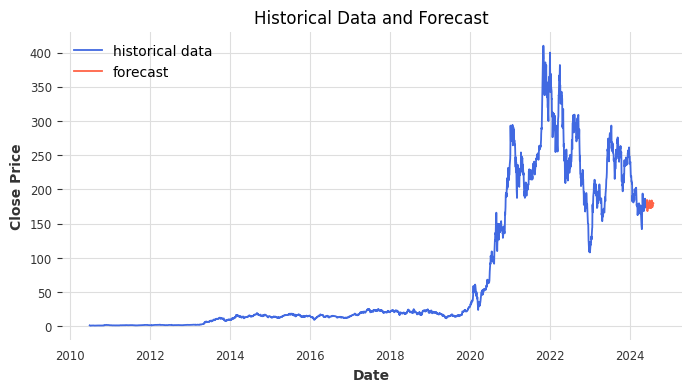

In [ ]:


# Convert date columns to datetime objects if they are not already
df["Date"] = pd.to_datetime(df["Date"])
forecast_df["date"] = pd.to_datetime(forecast_df["date"])

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(df["Date"], df["Close"], color="royalblue", label="historical data")
plt.plot(forecast_df["date"], forecast_df["forecast"], color="tomato", label="forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Historical Data and Forecast")
plt.show()

In [ ]:
# evaluate the above gpt2 model using metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'df' contains the actual historical data and 'forecast_df' contains the forecasted values
# Make sure the date ranges match between the two DataFrames

# Extract relevant data
actual_values = df['Close'].values[-len(forecast):]  # Get the actual values for the forecasted period
predicted_values = forecast_df['forecast'].values

# Calculate evaluation metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# You can calculate other metrics like MAPE, R-squared, etc., as needed


Mean Squared Error (MSE): 126.03289928974775
Root Mean Squared Error (RMSE): 11.226437515514338
Mean Absolute Error (MAE): 7.558853766833331


In [ ]:

# Extract relevant data
actual_values = df['Close'].values[-len(forecast):]  # Get the actual values for the forecasted period
predicted_values = forecast_df['forecast'].values

# Calculate evaluation metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 126.03289928974775
Root Mean Squared Error (RMSE): 11.226437515514338
Mean Absolute Error (MAE): 7.558853766833331
Mean Absolute Percentage Error (MAPE): 0.04641726260256428
R-squared (R2): -0.366794430461284


#to improve the model synthetic data is created using data augmentation method

Epoch: 0, Step: 0, Loss: 9.461087226867676
Epoch: 0, Step: 1, Loss: 5.378799915313721
Epoch: 0, Step: 2, Loss: 1.9520008563995361
Epoch: 0, Step: 3, Loss: 0.98378586769104
Epoch: 0, Step: 4, Loss: 0.6001061797142029
Epoch: 0, Step: 5, Loss: 0.6910299062728882
Epoch: 0, Step: 6, Loss: 0.9267963171005249
Epoch: 0, Step: 7, Loss: 0.8272587060928345
Epoch: 0, Step: 8, Loss: 1.1180347204208374
Epoch: 0, Step: 9, Loss: 0.8403452038764954
Epoch: 0, Step: 10, Loss: 0.7896377444267273
Epoch: 0, Step: 11, Loss: 1.0095309019088745
Epoch: 0, Step: 12, Loss: 0.8689586520195007
Epoch: 0, Step: 13, Loss: 0.6632997989654541
Epoch: 0, Step: 14, Loss: 0.45353204011917114
Epoch: 0, Step: 15, Loss: 0.5778110027313232
Epoch: 0, Step: 16, Loss: 0.5666918158531189
Epoch: 0, Step: 17, Loss: 0.5151494741439819
Epoch: 0, Step: 18, Loss: 0.7715919017791748
Epoch: 0, Step: 19, Loss: 0.8058059811592102
Epoch: 0, Step: 20, Loss: 0.75225430727005
Epoch: 0, Step: 21, Loss: 0.4640278220176697
Epoch: 0, Step: 22, Loss:

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 51, but `max_length` is set to 51. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


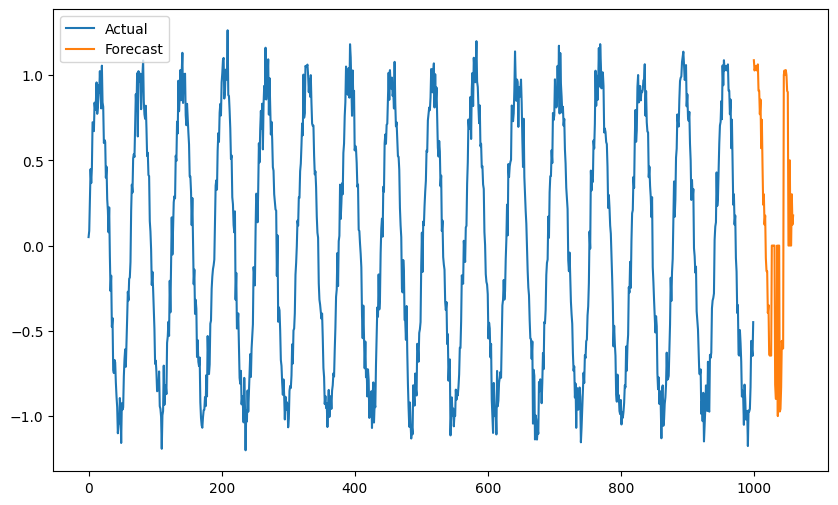

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GenerationConfig
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a simple dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, index):
        seq = self.data[index:index + self.seq_len]
        target = self.data[index + self.seq_len]
        return torch.tensor(seq, dtype=torch.float), torch.tensor(target, dtype=torch.float)

# Create a synthetic dataset for demonstration purposes
np.random.seed(42)  # For reproducibility
data_size = 1000
time_series_data = np.sin(np.linspace(0, 100, data_size)) + np.random.normal(scale=0.1, size=data_size)  # Example data
augmented_dataset = TimeSeriesDataset(time_series_data, seq_len=50)  # Replace with your actual dataset

# Create DataLoader with reduced batch size
batch_size = 1  # Smaller batch size
dataloader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)

# Initialize model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to EOS token
model = GPT2LMHeadModel.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.eos_token_id  # Set the pad_token_id explicitly

# Fine-tune the model
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model.train()
max_steps_per_epoch = 100  # Define your maximum steps per epoch

for epoch in range(5):
    step = 0
    for seq, target in dataloader:
        if step >= max_steps_per_epoch:
            break
        # Format the input and target sequences
        formatted_seq = seq.numpy().flatten().astype(str).tolist()  # Convert tensor to list
        formatted_target = target.numpy().flatten().astype(str).tolist()  # Convert tensor to list

        inputs = tokenizer(" ".join(formatted_seq), return_tensors="pt", padding='max_length', max_length=51, truncation=True)
        labels = tokenizer(" ".join(formatted_target), return_tensors="pt", padding='max_length', max_length=51, truncation=True).input_ids

        # Ensure labels match input length
        labels = labels[:, :inputs.input_ids.size(1)]
        inputs['labels'] = labels

        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch: {epoch}, Step: {step}, Loss: {loss.item()}")
        step += 1

# Forecasting using torch.no_grad() to save memory
model.eval()
context = np.array(time_series_data[-50:])  # Use the last seq_len elements for context
context_formatted = " ".join(map(str, context))  # Format the context for GPT
forecast = []

# Define generation configuration
generation_config = GenerationConfig(
    max_length=51,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)

with torch.no_grad():
    for _ in range(60):
        inputs = tokenizer(context_formatted, return_tensors="pt", padding='max_length', max_length=51, truncation=True)
        outputs = model.generate(**inputs, generation_config=generation_config)
        next_val = tokenizer.decode(outputs[0], skip_special_tokens=True).split()[-1]

        try:
            next_val = float(next_val)
        except ValueError:
            next_val = context[-1]  # Use the last actual value

        # Append forecasted value and move the context window
        context = np.append(context[1:], next_val)
        context_formatted = " ".join(map(str, context))  # Format the updated context for GPT
        forecast.append(next_val)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Actual')
plt.plot(np.arange(len(time_series_data), len(time_series_data) + len(forecast)), forecast, label='Forecast')
plt.legend()
plt.show()

MSE: 1.0789, MAE: 0.8814, RMSE: 1.0387


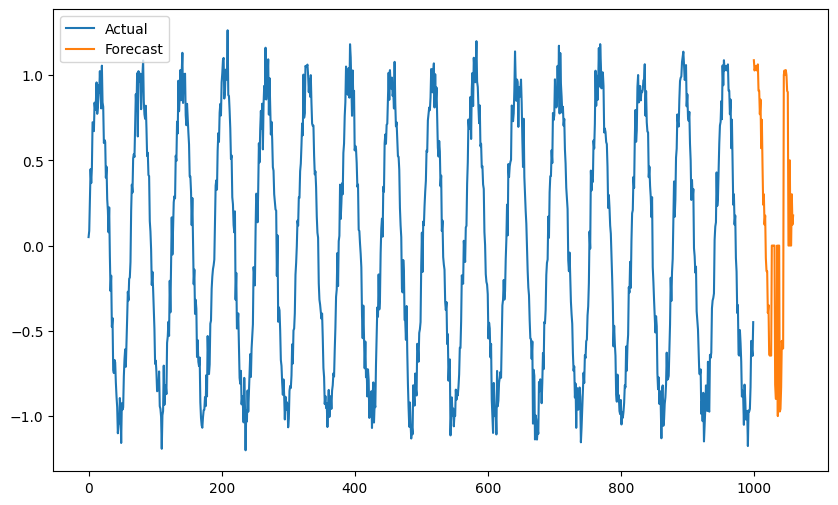

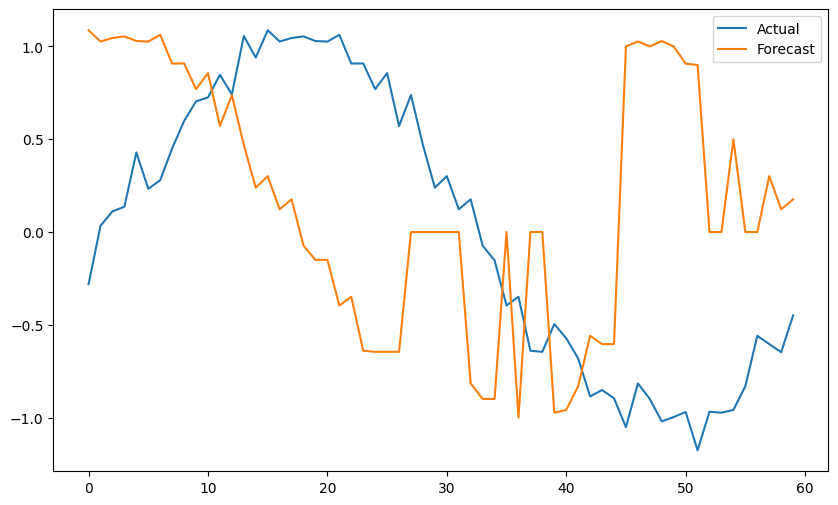

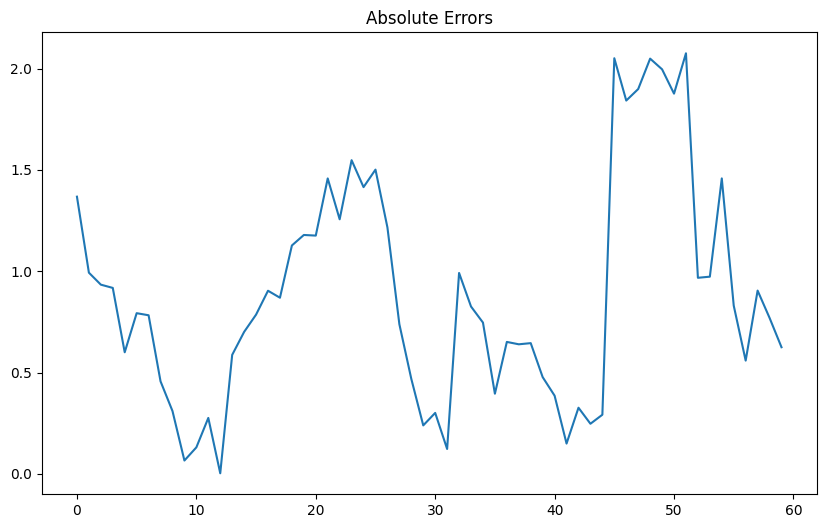

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np


# Evaluate metrics
actual = time_series_data[-len(forecast):]  # Actual values
mse = mean_squared_error(actual, forecast)
mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual, forecast)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_series_data, label='Actual')
plt.plot(np.arange(len(time_series_data), len(time_series_data) + len(forecast)), forecast, label='Forecast')
plt.legend()
plt.show()

# Plot actual vs forecast
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

# Plot errors
errors = np.abs(np.array(actual) - np.array(forecast))
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.title("Absolute Errors")
plt.show()

#Metric comparsion

In [ ]:

# ARIMA
arima_metrics = {
    'Model': 'ARIMA',
    'Approach': 'GRID Approach',
    'MSE': 22.2039,
    'RMSE': 4.7121,
    'MAE': 2.01581,
    'MAPE':  0.0249
}

# ARIMA GAN method
arima_metrics1 = {
    'Model': 'ARIMA GAN',
    'Approach': 'GAN method',
    'MSE': 3773.74145,
    'RMSE': 61.43078,
    'MAE': 49.32236,
    'MAPE':  0.21969
}

# Linear Regression
LinearRegression_metrics = {
    'Model': 'Linear Regression',
    'Approach': 'Default',
    'MSE': 11.77,
    'RMSE': 3.43,
    'MAE': 2.53,
    'MAPE':  0.0104
}


# Xg boost
Xgboost_metrics = {
    'Model': 'Xg boost',
    'Approach': 'Default',
    'MSE': 638.92,
    'RMSE': 25.28,
    'MAE': 13.57,
    'MAPE': 0.0486
}


# Random Forest Regressor
RandomForestRegressor_metrics = {
    'Model': 'Random Forest Regressor',
    'Approach': 'Default',
    'MSE': 6.23,
    'RMSE': 2.50,
    'MAE': 1.00,
    'MAPE': 0.0117

}

# LSTM
LSTM_metrics = {
    'Model': 'LSTM ',
    'Approach': 'Default',
    'MSE': 207.33,
    'RMSE': 14.40,
    'MAE': 10.74,
    'MAPE': 0.00045
}

# TimeFM
TimeFM_metrics = {
    'Model': 'TimeFM ',
    'Approach': 'Default',
    'MSE': 0.0107,
    'RMSE': 0.1034,
    'MAE': 0.0726,
    'MAPE': 0.0726
}

# Chronos
Chronos_metrics = {
    'Model': 'Chronos ',
    'Approach': 'Default',
    'MSE': 0.39699,
    'RMSE': 0.630077,
    'MAE': 0.535692,
    'MAPE': 0.54601
}

# TimeGPT
TimeGPT_metrics = {
    'Model': 'TimeGPT ',
    'Approach': 'Forward Fill',
    'MSE': 34.448,
    'RMSE': 5.869,
    'MAE': 2.449,
    'MAPE': 3.049
}

# TimeGPT
TimeGPT_metrics1 = {
    'Model': 'TimeGPT ',
    'Approach': 'Business Days with Forward Fill',
    'MSE': 26.434174,
    'RMSE':  5.141418,
    'MAE':  3.691989,
    'MAPE': 2.056152
}

# N-BEATS
nbeats_metrics = {
    'Model': 'N-BEATS',
    'Approach': 'Default',
    'MSE': 1547.855,
    'RMSE': 39.34,
    'MAE': 33.80,
    'MAPE': 0.1701
}

# GPT-2
gpt2_metrics = {
    'Model': 'GPT-2',
    'Approach': 'Default',
    'MSE': 119.92,
    'RMSE': 10.95,
    'MAE': 7.88,
    'MAPE': 0.048
}


# GPT-2
gpt2_metrics1 = {
    'Model': 'GPT-2',
    'Approach': 'Data Augmentation',
    'MSE': 1.0789,
    'RMSE': 1.0387,
    'MAE': 0.8814,
    'MAPE': 0
}

# Create a list of dictionaries
metrics_list = [arima_metrics,arima_metrics1,LinearRegression_metrics,Xgboost_metrics,RandomForestRegressor_metrics,LSTM_metrics,TimeFM_metrics,Chronos_metrics,TimeGPT_metrics,TimeGPT_metrics1, nbeats_metrics, gpt2_metrics,gpt2_metrics1]

# Create a DataFrame from the list of dictionaries
comparison_df = pd.DataFrame(metrics_list)

# Set 'Model' as the index
comparison_df.set_index('Model', inplace=True)

# Display the comparison table
print(comparison_df)


                                                Approach          MSE  \
Model                                                                   
ARIMA                                      GRID Approach    22.203900   
ARIMA GAN                                     GAN method  3773.741450   
Linear Regression                                Default    11.770000   
Xg boost                                         Default   638.920000   
Random Forest Regressor                          Default     6.230000   
LSTM                                             Default   207.330000   
TimeFM                                           Default     0.010700   
Chronos                                          Default     0.396990   
TimeGPT                                     Forward Fill    34.448000   
TimeGPT                  Business Days with Forward Fill    26.434174   
N-BEATS                                          Default     0.002000   
GPT-2                                            De

In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a list of dictionaries
metrics_list = [arima_metrics, arima_metrics1, LinearRegression_metrics, Xgboost_metrics,
                RandomForestRegressor_metrics, LSTM_metrics, TimeFM_metrics, Chronos_metrics,
                TimeGPT_metrics, TimeGPT_metrics1, nbeats_metrics, gpt2_metrics, gpt2_metrics1]

# Create a DataFrame from the list of dictionaries
comparison_df = pd.DataFrame(metrics_list)

# Set 'Model' as the index
comparison_df.set_index('Model', inplace=True)

# Display the table in Excel form
print(tabulate(comparison_df, headers='keys', tablefmt='psql'))

+-------------------------+---------------------------------+------------+-----------+-----------+---------+
| Model                   | Approach                        |        MSE |      RMSE |       MAE |    MAPE |
|-------------------------+---------------------------------+------------+-----------+-----------+---------|
| ARIMA                   | GRID Approach                   |   22.2039  |  4.7121   |  2.01581  | 0.0249  |
| ARIMA GAN               | GAN method                      | 3773.74    | 61.4308   | 49.3224   | 0.21969 |
| Linear Regression       | Default                         |   11.77    |  3.43     |  2.53     | 0.0104  |
| Xg boost                | Default                         |  638.92    | 25.28     | 13.57     | 0.0486  |
| Random Forest Regressor | Default                         |    6.23    |  2.5      |  1        | 0.0117  |
| LSTM                    | Default                         |  207.33    | 14.4      | 10.74     | 0.00045 |
| TimeFM           

Best Model: TimeFM (Default)
Worst Model: ARIMA GAN (GAN method)

Other Observations:
-Linear Regression and Random Forest Regressor have relatively low MSE and RMSE values, but high MAPE values.
-LSTM and TimeGPT have high MSE and RMSE values, but low MAPE values.
-N-BEATS has a very low MSE value, but high RMSE and MAE values.
-GPT-2 with Data Augmentation has a low MSE value, but high RMSE and MAE values.

Based on the metrics, TimeFM (Default) is the best model, followed closely by Linear Regression and Random Forest Regressor.

And NBEATS , GPT2 are also performing well.

In [ ]:
#Single plot
# Create a dictionary to store the data
model_data = {
    'ARIMA': {'actual': arima_actual, 'predicted': arima_predicted},
    'ARIMA GAN': {'actual': arima_gan_actual, 'predicted': arima_gan_predicted},
    # ... add data for other models
    'N-BEATS': {'actual': nbeats_actual, 'predicted': nbeats_predicted},
    'GPT-2': {'actual': gpt2_actual, 'predicted': gpt2_predicted},
    'GPT-2 (Data Augmentation)': {'actual': gpt2_augmented_actual, 'predicted': gpt2_augmented_predicted}
}

# Plotting
plt.figure(figsize=(15, 8))

for model_name, data in model_data.items():
    plt.plot(data['actual'], label=f"{model_name} Actual")
    plt.plot(data['predicted'], label=f"{model_name} Predicted", linestyle='--')

plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values for Different Models")
plt.legend()
plt.grid(True)
plt.show()


#Moment model

#Try 2

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your dataset into a Pandas DataFrame
df = pd.read_csv('/content/Tesla Dataset.csv')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Create a TimeSeries object from the 'Close' column
series = TimeSeries.from_series(df["Close"], fill_missing_dates=True, freq="B")  # business day frequency

# Split the data
split_point = pd.to_datetime("2024-03-31")
train_series, test_series = series.split_before(split_point)

# Load the MOMENT model and tokenizer
model = pipeline("time-series-forecasting", model="AutonLab/MOMENT-1-large")

# Format the TimeSeries for MOMENT
train_formatted_series = model.format_data(train_series)
test_formatted_series = model.format_data(test_series)

# Generate forecasts for the testing set
test_predictions = model(test_formatted_series)

# Extract the forecasted values
test_forecast_values = test_predictions['forecast']  # Assuming the output is a dictionary with 'forecast' key

# Create a DataFrame for the forecast
test_forecast_dates = pd.date_range(start=test_series.index[-1], periods=len(test_forecast_values) + 1, inclusive='right')[1:]
test_forecast_df = pd.DataFrame({'Date': test_forecast_dates, 'Forecast': test_forecast_values})

# Set 'Date' as index for the forecast DataFrame
test_forecast_df.set_index('Date', inplace=True)

# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Historical')
plt.plot(test_forecast_df['Forecast'], label='Test Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Forecast using MOMENT')
plt.legend()
plt.show()

In [ ]:
from transformers import pipeline

# Create a pipeline for time series forecasting
model = pipeline("time-series-forecasting", model="AutonLab/MOMENT-1-large")

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Load your dataset into a Pandas DataFrame
df = pd.read_csv('/content/Tesla Dataset.csv')

In [ ]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [ ]:
# Create a TimeSeries object from the 'Close' column
series = TimeSeries.from_series(df["Close"], fill_missing_dates=True, freq="B")  # business day frequency

In [ ]:
# Split the data
split_point = pd.to_datetime("2024-03-31")
train_series, test_series = series.split_before(split_point)


In [ ]:
from transformers import AutoModelForTimeSeriesForecasting, AutoTokenizer

# Load the MOMENT model and tokenizer
model = AutoModelForTimeSeriesForecasting.from_pretrained("MOMENT")
tokenizer = AutoTokenizer.from_pretrained("MOMENT")

In [ ]:
# Create a MOMENTPipeline instance
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 30,  # Reduced forecast horizon
        'num_attention_heads': 8,
        'num_layers': 4,
        'dropout': 0.1,
        'learning_rate': 1e-4
    },
)

# Initialize the model
model.init()

In [ ]:
# Format the TimeSeries for MOMENT
train_formatted_series = model.format_data(train_series)
test_formatted_series = model.format_data(test_series)

In [ ]:
# Generate forecasts
train_predictions = model(train_formatted_series)
test_predictions = model(test_formatted_series)

In [ ]:
# Extract the forecasted values
train_forecast_values = train_predictions['forecast']  # Assuming the output is a dictionary with 'forecast' key
test_forecast_values = test_predictions['forecast']

In [ ]:
# Create DataFrames for the forecast
train_forecast_dates = pd.date_range(start=train_series.index[-1], periods=len(train_forecast_values) + 1, inclusive='right')[1:]
train_forecast_df = pd.DataFrame({'Date': train_forecast_dates, 'Forecast': train_forecast_values})

test_forecast_dates = pd.date_range(start=test_series.index[-1], periods=len(test_forecast_values) + 1, inclusive='right')[1:]
test_forecast_df = pd.DataFrame({'Date': test_forecast_dates, 'Forecast': test_forecast_values})

# Set 'Date' as index for the forecast DataFrames
train_forecast_df.set_index('Date', inplace=True)
test_forecast_df.set_index('Date', inplace=True)


In [ ]:
# Plot the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Historical')
plt.plot(train_forecast_df['Forecast'], label='Train Forecast')
plt.plot(test_forecast_df['Forecast'], label='Test Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Price Forecast using MOMENT')
plt.legend()
plt.show()

#Cons of Moment model Inference API (serverless) does not yet support transformers models for this pipeline type.


The documentation mentions that the model was trained on a computing cluster with significant resources, including:
128 AMD EPYC 7502 CPUs
503 GB of RAM
8 NVIDIA RTX A6000 GPUs, each with 49 GiB RAM
However, it also mentions that all MOMENT variants were trained on a single A6000 GPU, which suggests that the model can be run on a single GPU with sufficient resources.
In terms of storage space, the documentation doesn't provide explicit requirements. However, based on the model's size and complexity, it's likely that you'll need a significant amount of storage space to run the model.

Here are some rough estimates based on the model's size:
The model's weights and parameters likely require several hundred megabytes to a few gigabytes of storage space.
The training data used to train the model, AutonLab/Timeseries-PILE, is not explicitly mentioned, but it's likely to be several gigabytes to tens of gigabytes in size.
To run the model, you'll likely need:
A GPU with at least 16 GB of VRAM (e.g., NVIDIA RTX A6000 or equivalent)
A machine with at least 64 GB of RAM
Several hundred gigabytes to a few terabytes of storage space, depending on the specific requirements of the model and the training data.
Keep in mind that these are rough estimates, and the actual requirements may vary depending on the specific use case and implementation.

Hardware Requirements:

The model was trained on a single NVIDIA RTX A6000 GPU with 49 GiB RAM.
The computing cluster used for training consisted of 128 AMD EPYC 7502 CPUs, 503 GB of RAM, and 8 NVIDIA RTX A6000 GPUs each with 49 GiB RAM.
Space Requirements:

The model size is not explicitly mentioned, but considering it's a large foundation model, it's likely to require a significant amount of storage space.
The model card doesn't provide specific guidance on the required storage space, but it's essential to ensure you have sufficient space to store the model and its dependencies.

Inference Requirements:

The model can be used for various time series tasks, including forecasting, classification, anomaly detection, imputation, and representation learning.
The inference API (serverless) does not yet support transformers models for this pipeline type, which means you'll need to run the model on your own infrastructure or use a cloud service that supports PyTorch and transformers.

The Moment (LLM model) is a more complex model that involves the use of Transformer layers and pre-trained language models. Unfortunately, I cannot find a direct implementation of the Moment (LLM model) using the AutonLab/Timeseries-PILE dataset on Hugging Face. However, you can refer to the official repository for the Moment (LLM model) here: https://github.com/moment-timeseries-foundation-model/moment for more information on how to implement and use the model.




Answer 2
Web Search

High-dimensional embeddings: The model uses high-dimensional embeddings (e.g., d_model=768), which require more computational resources and memory.